In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-resnet50-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [11]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.1855
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 109s - loss: 0.5825 - acc: 0.8349 - val_loss: 10.1830 - val_acc: 0.1211
Epoch 2/100
9112/9112 [==============================] - 98s - loss: 0.2504 - acc: 0.9260 - val_loss: 3.7626 - val_acc: 0.3672
Epoch 3/100
9112/9112 [==============================] - 97s - loss: 0.1552 - acc: 0.9503 - val_loss: 0.3871 - val_acc: 0.8750
Epoch 4/100
9112/9112 [==============================] - 97s - loss: 0.1157 - acc: 0.9643 - val_loss: 3.9245 - val_acc: 0.5928
Epoch 5/100
9112/9112 [==============================] - 97s - loss: 0.0920 - acc: 0.9701 - val_loss: 0.5243 - val_acc: 0.8516
Epoch 6/100
9112/9112 [==============================] - 98s - loss: 0.0913 - acc: 0.9693 - val_loss: 0.4017 - val_acc: 0.8838
Epoch 7/100
9112/9112 [==============================] - 97s - loss: 0.3316 - acc: 0.9136 - val_loss: 5.9953 - val_acc: 0.3672
Epoch 8/100
9112/9112 [=========

9114/9114 [==============================] - 96s - loss: 0.0988 - acc: 0.9698 - val_loss: 0.3732 - val_acc: 0.8914
Epoch 26/100
9114/9114 [==============================] - 96s - loss: 0.0763 - acc: 0.9805 - val_loss: 0.4700 - val_acc: 0.8757
Epoch 27/100
9114/9114 [==============================] - 96s - loss: 0.0557 - acc: 0.9830 - val_loss: 0.4455 - val_acc: 0.8963
Epoch 28/100
9114/9114 [==============================] - 96s - loss: 0.0477 - acc: 0.9862 - val_loss: 0.4240 - val_acc: 0.8904
Epoch 29/100
9114/9114 [==============================] - 96s - loss: 0.0483 - acc: 0.9850 - val_loss: 0.4456 - val_acc: 0.9012
Epoch 30/100
9114/9114 [==============================] - 97s - loss: 0.0381 - acc: 0.9907 - val_loss: 0.3541 - val_acc: 0.9041
Epoch 31/100
9114/9114 [==============================] - 96s - loss: 0.0500 - acc: 0.9863 - val_loss: 0.4101 - val_acc: 0.9100
Epoch 32/100
9114/9114 [==============================] - 97s - loss: 0.0379 - acc: 0.9905 - val_loss: 0.4552 - val_a

9114/9114 [==============================] - 95s - loss: 0.0027 - acc: 0.9997 - val_loss: 0.4619 - val_acc: 0.9335
Epoch 90/100
9114/9114 [==============================] - 95s - loss: 0.0028 - acc: 0.9997 - val_loss: 0.4591 - val_acc: 0.9295
Epoch 91/100
9114/9114 [==============================] - 94s - loss: 0.0026 - acc: 0.9997 - val_loss: 0.4494 - val_acc: 0.9325
Epoch 92/100
9114/9114 [==============================] - 95s - loss: 0.0027 - acc: 0.9996 - val_loss: 0.4447 - val_acc: 0.9354
Epoch 93/100
9114/9114 [==============================] - 94s - loss: 0.1318 - acc: 0.9613 - val_loss: 1.2994 - val_acc: 0.7867
Epoch 94/100
9114/9114 [==============================] - 94s - loss: 0.0255 - acc: 0.9924 - val_loss: 1.1201 - val_acc: 0.7681
Epoch 95/100
9114/9114 [==============================] - 94s - loss: 0.0086 - acc: 0.9984 - val_loss: 0.4243 - val_acc: 0.9119
Epoch 96/100
9114/9114 [==============================] - 95s - loss: 0.0049 - acc: 0.9993 - val_loss: 0.3775 - val_a

9120/9120 [==============================] - 97s - loss: 0.0412 - acc: 0.9879 - val_loss: 0.4602 - val_acc: 0.9006
Epoch 14/100
9120/9120 [==============================] - 98s - loss: 0.0599 - acc: 0.9803 - val_loss: 0.6115 - val_acc: 0.8504
Epoch 15/100
9120/9120 [==============================] - 97s - loss: 0.0490 - acc: 0.9844 - val_loss: 0.5135 - val_acc: 0.8809
Epoch 16/100
9120/9120 [==============================] - 98s - loss: 0.0281 - acc: 0.9921 - val_loss: 0.8205 - val_acc: 0.8189
Epoch 17/100
9120/9120 [==============================] - 97s - loss: 0.0337 - acc: 0.9897 - val_loss: 0.4796 - val_acc: 0.8878
Epoch 18/100
9120/9120 [==============================] - 97s - loss: 0.0131 - acc: 0.9969 - val_loss: 0.3447 - val_acc: 0.9163
Epoch 19/100
9120/9120 [==============================] - 98s - loss: 0.0084 - acc: 0.9987 - val_loss: 0.5696 - val_acc: 0.8967
Epoch 20/100
9120/9120 [==============================] - 98s - loss: 0.0151 - acc: 0.9955 - val_loss: 0.5449 - val_a

9120/9120 [==============================] - 98s - loss: 0.0337 - acc: 0.9898 - val_loss: 0.4234 - val_acc: 0.9144
Epoch 39/100
9120/9120 [==============================] - 98s - loss: 0.0293 - acc: 0.9906 - val_loss: 0.3336 - val_acc: 0.9301
Epoch 40/100
9120/9120 [==============================] - 98s - loss: 0.0141 - acc: 0.9964 - val_loss: 0.4022 - val_acc: 0.9193
Epoch 41/100
9120/9120 [==============================] - 99s - loss: 0.0190 - acc: 0.9939 - val_loss: 0.4835 - val_acc: 0.9104
Epoch 42/100
9120/9120 [==============================] - 98s - loss: 0.0213 - acc: 0.9936 - val_loss: 0.5759 - val_acc: 0.9055
Epoch 43/100
9120/9120 [==============================] - 99s - loss: 0.0087 - acc: 0.9973 - val_loss: 0.4350 - val_acc: 0.9301
Epoch 44/100
9120/9120 [==============================] - 99s - loss: 0.0068 - acc: 0.9978 - val_loss: 0.3700 - val_acc: 0.9360
Epoch 45/100
9120/9120 [==============================] - 98s - loss: 0.0087 - acc: 0.9971 - val_loss: 0.4208 - val_a

9125/9125 [==============================] - 95s - loss: 2.9203 - acc: 0.2610 - val_loss: 13.1534 - val_acc: 0.0495
Epoch 2/100
9125/9125 [==============================] - 97s - loss: 2.3668 - acc: 0.4171 - val_loss: 3.0352 - val_acc: 0.4055
Epoch 3/100
9125/9125 [==============================] - 97s - loss: 1.6804 - acc: 0.6163 - val_loss: 1.6694 - val_acc: 0.5717
Epoch 4/100
9125/9125 [==============================] - 97s - loss: 1.3124 - acc: 0.6722 - val_loss: 1.8589 - val_acc: 0.4718
Epoch 5/100
9125/9125 [==============================] - 97s - loss: 0.7541 - acc: 0.7878 - val_loss: 2.1431 - val_acc: 0.3521
Epoch 6/100
9125/9125 [==============================] - 98s - loss: 0.4866 - acc: 0.8512 - val_loss: 1.1752 - val_acc: 0.6311
Epoch 7/100
9125/9125 [==============================] - 97s - loss: 0.3942 - acc: 0.8815 - val_loss: 1.0234 - val_acc: 0.7339
Epoch 8/100
9125/9125 [==============================] - 98s - loss: 0.3017 - acc: 0.9068 - val_loss: 0.3619 - val_acc: 0.

9127/9127 [==============================] - 98s - loss: 0.0203 - acc: 0.9934 - val_loss: 0.6602 - val_acc: 0.8821
Epoch 28/100
9127/9127 [==============================] - 99s - loss: 0.0308 - acc: 0.9899 - val_loss: 0.8488 - val_acc: 0.8157
Epoch 29/100
9127/9127 [==============================] - 99s - loss: 0.0222 - acc: 0.9931 - val_loss: 0.5023 - val_acc: 0.9158
Epoch 30/100
9127/9127 [==============================] - 99s - loss: 0.0161 - acc: 0.9953 - val_loss: 0.3462 - val_acc: 0.9336
Epoch 31/100
9127/9127 [==============================] - 98s - loss: 0.0185 - acc: 0.9944 - val_loss: 1.5876 - val_acc: 0.6571
Epoch 32/100
9127/9127 [==============================] - 99s - loss: 0.0212 - acc: 0.9928 - val_loss: 0.4030 - val_acc: 0.9296
Epoch 33/100
9127/9127 [==============================] - 99s - loss: 0.0195 - acc: 0.9947 - val_loss: 1.3227 - val_acc: 0.6392
Epoch 34/100
9127/9127 [==============================] - 99s - loss: 0.6192 - acc: 0.8765 - val_loss: 14.3835 - val_

9127/9127 [==============================] - 98s - loss: 7.8074e-04 - acc: 0.9999 - val_loss: 0.3554 - val_acc: 0.9445
Epoch 92/100
9127/9127 [==============================] - 99s - loss: 7.3077e-04 - acc: 0.9999 - val_loss: 0.3580 - val_acc: 0.9435
Epoch 93/100
9127/9127 [==============================] - 98s - loss: 5.5811e-04 - acc: 0.9999 - val_loss: 0.3511 - val_acc: 0.9465
Epoch 94/100
9127/9127 [==============================] - 98s - loss: 6.2921e-04 - acc: 0.9999 - val_loss: 0.3574 - val_acc: 0.9445
Epoch 95/100
9127/9127 [==============================] - 99s - loss: 0.0058 - acc: 0.9993 - val_loss: 0.3493 - val_acc: 0.9455
Epoch 96/100
9127/9127 [==============================] - 98s - loss: 6.5158e-04 - acc: 0.9999 - val_loss: 0.3577 - val_acc: 0.9425
Epoch 97/100
9127/9127 [==============================] - 99s - loss: 6.7884e-04 - acc: 0.9999 - val_loss: 0.3456 - val_acc: 0.9465
Epoch 98/100
9127/9127 [==============================] - 100s - loss: 6.4221e-04 - acc: 0.99

9130/9130 [==============================] - 99s - loss: 0.3283 - acc: 0.9012 - val_loss: 0.4489 - val_acc: 0.8877
Epoch 16/100
9130/9130 [==============================] - 99s - loss: 0.2217 - acc: 0.9294 - val_loss: 0.3224 - val_acc: 0.9026
Epoch 17/100
9130/9130 [==============================] - 98s - loss: 0.1661 - acc: 0.9462 - val_loss: 0.3166 - val_acc: 0.9115
Epoch 18/100
9130/9130 [==============================] - 98s - loss: 0.1311 - acc: 0.9594 - val_loss: 0.3782 - val_acc: 0.9006
Epoch 19/100
9130/9130 [==============================] - 98s - loss: 0.1072 - acc: 0.9653 - val_loss: 0.3772 - val_acc: 0.9195
Epoch 20/100
9130/9130 [==============================] - 99s - loss: 0.0844 - acc: 0.9729 - val_loss: 0.3002 - val_acc: 0.9155
Epoch 21/100
9130/9130 [==============================] - 98s - loss: 0.0682 - acc: 0.9783 - val_loss: 0.2615 - val_acc: 0.9294
Epoch 22/100
9130/9130 [==============================] - 99s - loss: 0.0566 - acc: 0.9830 - val_loss: 0.4489 - val_a

9132/9132 [==============================] - 97s - loss: 0.0307 - acc: 0.9905 - val_loss: 1.1041 - val_acc: 0.7420
Epoch 41/100
9132/9132 [==============================] - 97s - loss: 0.0120 - acc: 0.9973 - val_loss: 0.2648 - val_acc: 0.9373
Epoch 42/100
9132/9132 [==============================] - 97s - loss: 0.0039 - acc: 0.9998 - val_loss: 0.2976 - val_acc: 0.9402
Epoch 43/100
9132/9132 [==============================] - 97s - loss: 0.0031 - acc: 0.9993 - val_loss: 0.3259 - val_acc: 0.9432
Epoch 44/100
9132/9132 [==============================] - 97s - loss: 0.0176 - acc: 0.9942 - val_loss: 1.9455 - val_acc: 0.6185
Epoch 45/100
9132/9132 [==============================] - 97s - loss: 0.0311 - acc: 0.9924 - val_loss: 0.5054 - val_acc: 0.8924
Epoch 46/100
9132/9132 [==============================] - 97s - loss: 0.0521 - acc: 0.9890 - val_loss: 1.5814 - val_acc: 0.6673
Epoch 47/100
9132/9132 [==============================] - 97s - loss: 0.0360 - acc: 0.9892 - val_loss: 0.3558 - val_a

In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8576


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

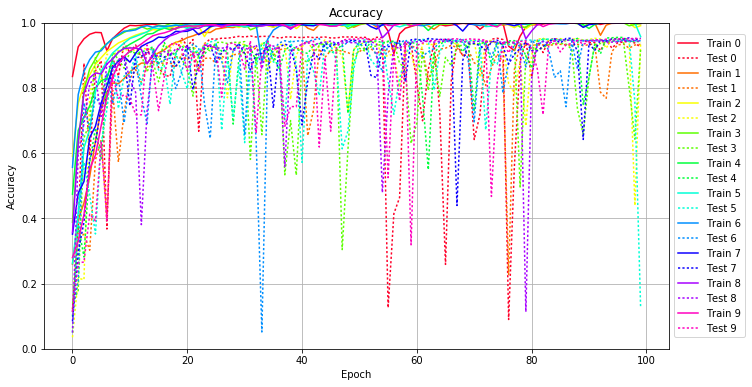

In [14]:
plot_acc(history)

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

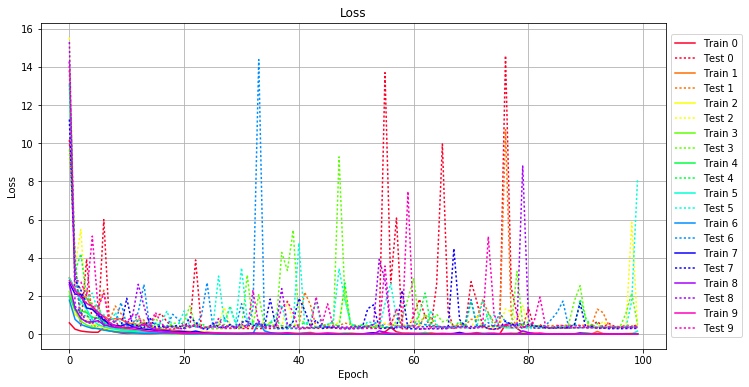

In [16]:
plot_loss(history)

Plotting the confusion matrix


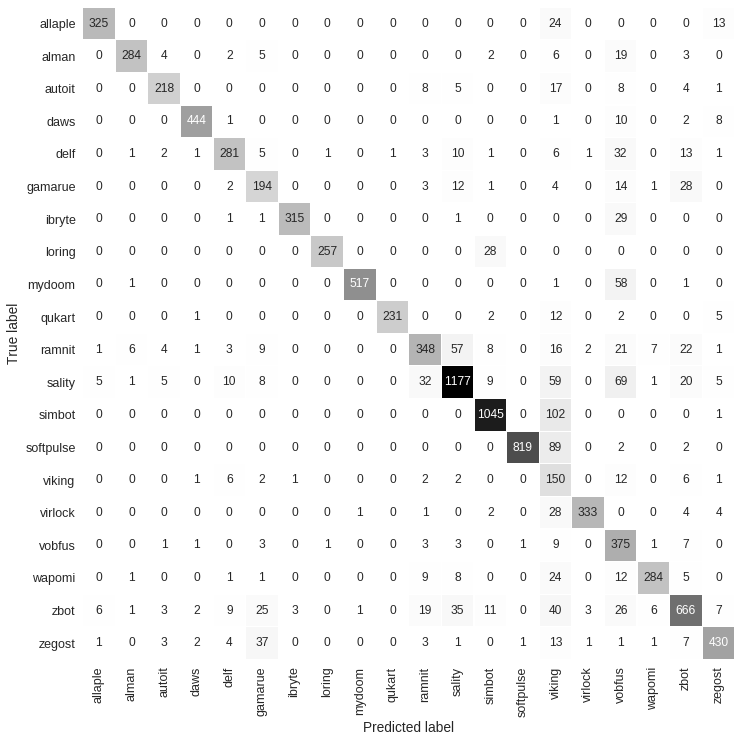

In [29]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


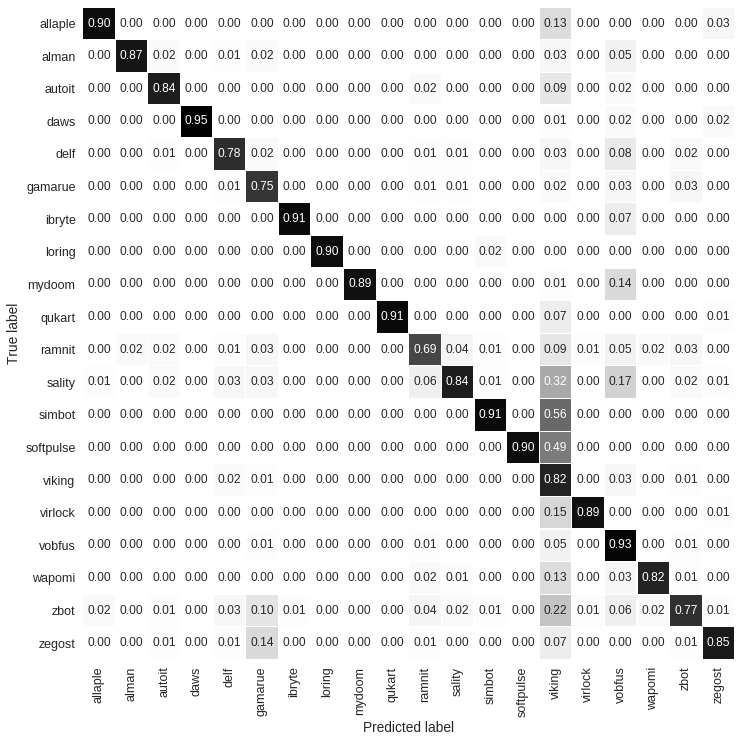

In [28]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
for h in history:
    print(h.history)

{'acc': [0.83494293250150065, 0.92603160672485041, 0.95028533801580328, 0.96433274802458302, 0.9701492538360047, 0.96927129071045592, 0.91363037757647469, 0.95116330119368275, 0.96762510985005201, 0.98298946454715475, 0.99165935030728714, 0.99067164179104472, 0.9918788410886743, 0.99407374890254607, 0.99506145741878838, 0.99198858658402922, 0.98858647936786659, 0.98463564535522796, 0.98013608428446009, 0.99637840221177287, 0.99692712906057945, 0.9990122914837577, 0.99912203687445122, 0.99824407374890256, 0.99956101843722567, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

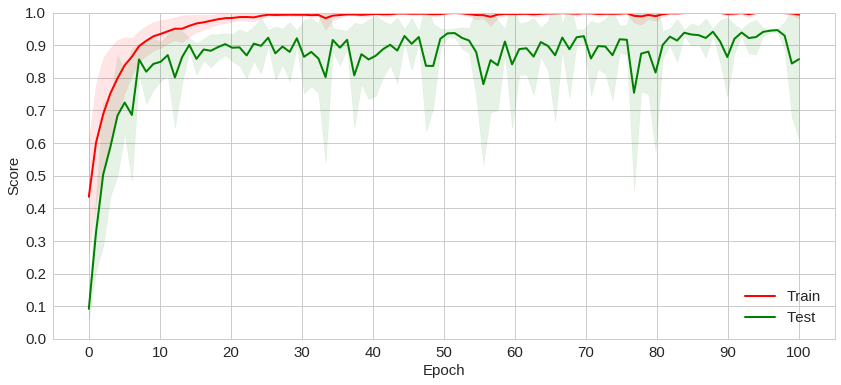

In [21]:
plot_mean_acc(history)

In [22]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

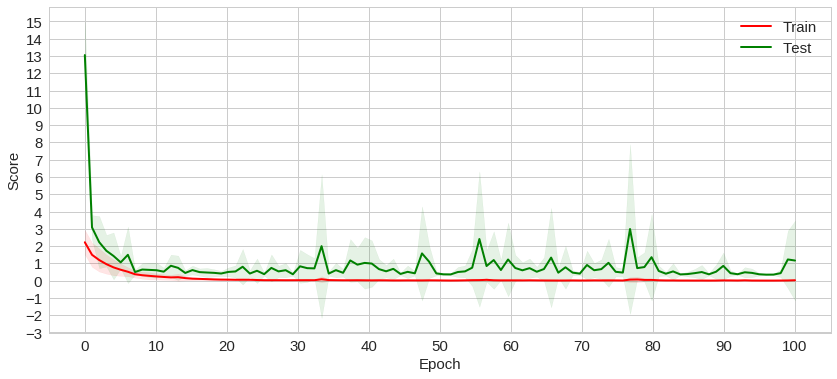

In [23]:
plot_mean_loss(history)

In [30]:
history= [{'acc': [0.83494293250150065, 0.92603160672485041, 0.95028533801580328, 0.96433274802458302, 0.9701492538360047, 0.96927129071045592, 0.91363037757647469, 0.95116330119368275, 0.96762510985005201, 0.98298946454715475, 0.99165935030728714, 0.99067164179104472, 0.9918788410886743, 0.99407374890254607, 0.99506145741878838, 0.99198858658402922, 0.98858647936786659, 0.98463564535522796, 0.98013608428446009, 0.99637840221177287, 0.99692712906057945, 0.9990122914837577, 0.99912203687445122, 0.99824407374890256, 0.99956101843722567, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.97410008784864321, 0.90452151020123728, 0.96586918359895457, 0.98287971915646122, 0.98814749780509215, 0.99363476733977174, 0.99209833187006147, 0.99670763827919229, 0.99824407385356395, 0.99440298512695757, 0.99023266022827039, 0.99242756814680355, 0.99561018437225635, 0.99780509218612823, 0.99714661984196662, 0.99539069359086918, 0.97947761194029848, 0.99341527661071527, 0.99945127304653203, 0.9996707638279192, 0.99945127304653203, 0.92767778758525432, 0.91439859525899914, 0.95840649692712909, 0.98672080772607551, 0.99363476739210244, 0.99341527655838457, 0.99571992976294998, 0.99846356453028973, 0.99945127304653203, 0.99978050921861283, 0.99945127304653203, 0.99978050921861283, 0.99934152776049978, 0.99824407374890256, 0.99813432846287031, 0.99802458307217667, 0.99440298507462688, 0.99846356453028973, 0.99780509218612823, 0.99824407374890256, 0.99868305531167689, 0.9990122914837577, 0.99890254609306406, 0.99714661984196662], 'loss': [0.58247379297954771, 0.25036433218758392, 0.1551897537201983, 0.1156659102046092, 0.092003669357540521, 0.091285230806121914, 0.33163575381956362, 0.16349650768986704, 0.10490133396175684, 0.05207329756262221, 0.026388653312810584, 0.031656743710839354, 0.024842885687139417, 0.018975988833382529, 0.014903126097029963, 0.02528692735583931, 0.045191443940425083, 0.048630870039361389, 0.062856150697834984, 0.013244265502178101, 0.0077091833882980687, 0.0042827380371392035, 0.0029812706832430974, 0.0056470917276461646, 0.0023698411790242777, 0.00086882621565598814, 0.00085091862443849265, 0.00068248158833525581, 0.00066493003003933082, 0.00073673670241997146, 0.00056864618485053691, 0.00058938807037492793, 0.00051099218463550116, 0.00061024059667239743, 0.00072087888526349, 0.00065317883958058184, 0.00048700988709378412, 0.00068460237294622748, 0.00058945170431918604, 0.00060670029457793545, 0.00047210771062996279, 0.00061066667513411425, 0.00056009551603377727, 0.00062560407657846512, 0.00063184209884287787, 0.00050885521099208806, 0.00059094126790656574, 0.0006047672941361424, 0.00047473956796920705, 0.00072155578820011306, 0.00054990314692044198, 0.00063697487210709347, 0.00080930738659574098, 0.00072028637408652022, 0.00065050503658843671, 0.11500133719936369, 0.33924092713471982, 0.10888297621674241, 0.052920586824469443, 0.035010384415751411, 0.019894729154568764, 0.024927846080426509, 0.010638787449174826, 0.006717623682368442, 0.018249438375972957, 0.032102237003377075, 0.022973409949951496, 0.014823085175615779, 0.0073036706864938496, 0.011966567800661975, 0.024507813866254714, 0.071823573318866907, 0.023721519033436823, 0.0042343561664710998, 0.001589356993619006, 0.0066556665441358607, 0.49682017874135781, 0.55681284281561727, 0.29309119428389424, 0.083545390179640799, 0.046851829623621971, 0.038518287122897198, 0.033710544318315605, 0.0093888302633736726, 0.0046230110789434956, 0.0033241447487866865, 0.0019087232300029255, 0.0015063646490818972, 0.003382161321793867, 0.0064099828894675281, 0.0077605307077877779, 0.0091088036973339271, 0.022348915498018512, 0.0076426100987352103, 0.0068107473850669295, 0.0053660988689014314, 0.0055756050585824305, 0.0030352250483842475, 0.0050694130280488879, 0.011355537810766906], 'val_acc': [0.12109375, 0.3671875, 0.875, 0.5927734375, 0.8515625, 0.8837890625, 0.3671875, 0.8935546875, 0.8359375, 0.9375, 0.908203125, 0.931640625, 0.892578125, 0.90625, 0.9228515625, 0.8623046875, 0.8388671875, 0.8349609375, 0.9052734375, 0.953125, 0.927734375, 0.9482421875, 0.6669921875, 0.9345703125, 0.9501953125, 0.94921875, 0.9521484375, 0.9521484375, 0.955078125, 0.9580078125, 0.9560546875, 0.958984375, 0.9560546875, 0.9580078125, 0.9580078125, 0.95703125, 0.9521484375, 0.9560546875, 0.9560546875, 0.955078125, 0.9541015625, 0.9560546875, 0.9541015625, 0.955078125, 0.9560546875, 0.953125, 0.953125, 0.9560546875, 0.9560546875, 0.9560546875, 0.9541015625, 0.955078125, 0.9462890625, 0.955078125, 0.9541015625, 0.1259765625, 0.4140625, 0.4638671875, 0.93359375, 0.9365234375, 0.8134765625, 0.69921875, 0.85546875, 0.9375, 0.7255859375, 0.2587890625, 0.8212890625, 0.935546875, 0.8984375, 0.90234375, 0.6416015625, 0.7177734375, 0.9150390625, 0.94921875, 0.9521484375, 0.9482421875, 0.08984375, 0.55859375, 0.8798828125, 0.9423828125, 0.8330078125, 0.9462890625, 0.908203125, 0.947265625, 0.951171875, 0.9462890625, 0.9443359375, 0.9501953125, 0.943359375, 0.9462890625, 0.9384765625, 0.939453125, 0.9140625, 0.9462890625, 0.921875, 0.9384765625, 0.9404296875, 0.943359375, 0.9375, 0.9248046875], 'val_loss': [10.182962000370026, 3.7626055078580976, 0.38714860439358745, 3.9244641072655213, 0.52426153619308025, 0.40169991663424298, 5.9952693432569504, 0.39939369233024991, 0.66611214640144567, 0.29479063117651094, 0.44154063117093756, 0.34572411470526276, 0.71766998081579914, 0.43773934113050927, 0.39529530982895267, 0.9352593286457882, 1.0547341252677143, 0.64254588191397488, 0.36953077248199406, 0.26075437895607934, 0.46878678137386487, 0.35462283680442397, 3.8818296022874961, 0.36047215288317602, 0.30224150304488262, 0.28424479426405469, 0.29265800737019276, 0.2887429256911247, 0.2895017195305627, 0.2911820588186913, 0.29015021675068198, 0.28584502466108574, 0.28081340266244581, 0.28596804334591752, 0.28710538634368987, 0.28535349254337206, 0.29552970259151934, 0.29221495829988697, 0.29114944665457543, 0.29816287431157917, 0.29378871794722272, 0.28847567364616467, 0.29659954251453158, 0.2933737230853648, 0.30228404350828875, 0.30769136793319873, 0.31191794055638589, 0.29693994675692537, 0.30536758971086009, 0.30952172065108385, 0.31294879057606817, 0.32391896000761022, 0.36793273572281837, 0.31247595791742899, 0.30524696934106288, 13.696991287171841, 2.6469940692186356, 6.0773310411022976, 0.27498847269453108, 0.27064484865695704, 0.98255469610012369, 1.821723158343957, 0.929956863859843, 0.28164269899559713, 2.6159468852565624, 9.9612478092312813, 1.1629227281882777, 0.28950698084099713, 0.51829212827635729, 0.44435681282993755, 2.7433754373341808, 1.7086594610009342, 0.42737445200549473, 0.27863014063268565, 0.23989250562954112, 0.27942337528739358, 14.588979184627533, 2.4322466654703021, 1.0190190526773222, 0.32923860856158171, 1.3615758937958162, 0.30200008719907601, 0.4889725338609594, 0.30158540661579991, 0.30340111277115511, 0.31163734411694577, 0.31019492400218951, 0.31095895103067051, 0.318239493196387, 0.34407929257224623, 0.37294048420628201, 0.40363718763012457, 0.66092792141728296, 0.36804805646755767, 0.55696079599903214, 0.39530286151739347, 0.3734981962550421, 0.34106297852935086, 0.3893950141842879, 0.47067123865599569]},
{'acc': [0.25960061445567384, 0.39543559361843522, 0.44722405106764446, 0.52775949099776986, 0.63561553666799353, 0.73974105768724829, 0.78768926938688755, 0.81490015380602798, 0.81303489155902242, 0.82839587468810061, 0.84847487392513432, 0.86449418487532081, 0.87590520107774905, 0.87634408603458513, 0.89653280686725245, 0.90750493755041306, 0.91650208470484973, 0.93120474006513876, 0.93943383815598791, 0.94459073970473229, 0.95402677210376063, 0.95940311617670238, 0.96664472249664968, 0.97004608313242591, 0.96982664033355281, 0.98046960721079757, 0.9829931973704702, 0.98617511529893187, 0.98496818091227401, 0.99067368892192942, 0.98628483660680988, 0.99045424630617351, 0.99155145929339483, 0.99144173816863401, 0.99231950844854067, 0.98650427913100724, 0.99330700021944263, 0.99528198376124644, 0.99758613122668427, 0.99791529515031818, 0.99879306561334213, 0.98288347615415073, 0.97640991889779072, 0.99473337731341505, 0.99583059030063636, 0.99802501645819619, 0.99791529515031818, 0.99857362299758612, 0.99824445925706939, 0.98573623006741995, 0.99341672161887917, 0.99780557384244017, 0.99868334448858131, 0.98650427913100724, 0.99583059030063636, 0.9981347377660742, 0.99857362299758612, 0.99901250822909804, 0.99956111476848808, 0.99967083607636598, 0.99956111476848808, 0.99945139346061007, 0.99001536116622013, 0.97970155804257186, 0.99319727891156462, 0.99824445907395221, 0.99945139355216861, 0.99945139346061007, 0.99912222953697605, 0.99594031160851437, 0.99407504937458857, 0.991222295552878, 0.99188062321702875, 0.99780557384244017, 0.99769585253456217, 0.99231950844854067, 0.99506254114549042, 0.99901250822909804, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083607636598, 0.99967083616792463, 0.99967083607636598, 0.99956111486004662, 0.96126837841062818, 0.99242922984797732, 0.9983541803818301, 0.9993416722442906, 0.99956111476848808, 0.99945139346061007, 0.99967083607636598, 0.99967083607636598], 'loss': [2.9504337744517155, 2.3350919049011658, 2.0779969574512034, 1.8779212637169465, 1.3782291824628785, 1.0844268853501686, 0.94266824484760892, 0.75177382951978788, 0.80454457462788775, 0.79389313843680864, 0.56477148435553726, 0.53859830607650105, 0.48898852091231104, 0.6180417182834258, 0.42088965202780021, 0.29715833847450013, 0.25240925307568945, 0.21424017443399512, 0.19577348926806623, 0.17210729045775838, 0.14798984087191053, 0.13220502224268296, 0.11235558822185344, 0.094176483757275622, 0.098757315328148909, 0.076346200732042166, 0.055710707506459616, 0.047721800556831881, 0.048271271529521029, 0.03806946325098079, 0.049994561794245218, 0.037900414323568714, 0.033217973660821548, 0.030983526791845049, 0.030140017047083009, 0.044100213813271956, 0.026297925649971483, 0.019542218583260145, 0.012404365720299045, 0.0093502577763955753, 0.0076162431161014401, 0.058824430748334718, 0.083611387219087896, 0.019696054052310553, 0.018492889580138425, 0.010498196478543104, 0.0087654401876428017, 0.0083904211125926196, 0.0096267388172207348, 0.044682518628728164, 0.023915993237354161, 0.010721739153268373, 0.0069414966691993315, 0.045621862337246639, 0.017685741600403732, 0.0093618751664367814, 0.0072069971803859828, 0.0052387039187976985, 0.0040180555403955846, 0.0033205019554711566, 0.0031387804820806617, 0.0034866237511483526, 0.036350023732930406, 0.067568864460624975, 0.022297194132722166, 0.0088340376708884675, 0.0041161160308083719, 0.0041853252284374722, 0.0050204540007885252, 0.014334555096382311, 0.018418847816907988, 0.025426914545733769, 0.026612207321534929, 0.0088099856836002313, 0.012756016549564585, 0.026635747968709919, 0.017857776272730091, 0.0057816931415130158, 0.0034910789413221503, 0.0031285890037293426, 0.0027971480395484472, 0.0027735442878477749, 0.0026345305080064819, 0.0027423369454283087, 0.0027488453970489217, 0.0026419875984587259, 0.0025916649313438285, 0.0026891056414321025, 0.0027260675645142079, 0.0028209800195470162, 0.0026166396660443664, 0.0026552575070700204, 0.1318229028536344, 0.025489269967714317, 0.0086290488299038577, 0.004924612834916583, 0.003134285910317659, 0.004159584117242778, 0.0032890530278136152, 0.0028480823869214676], 'val_acc': [0.11252446183953033, 0.33855185904148272, 0.35127201460578905, 0.3023483342620491, 0.57925635681226995, 0.640900193828426, 0.40313111452673744, 0.79256359821662981, 0.57240704407663956, 0.72309197255076729, 0.82778864620716375, 0.85616438006234963, 0.81604696358253348, 0.86301369513084281, 0.8816046950401859, 0.87573385261976089, 0.87573385261976089, 0.87769080164847779, 0.86203522329927662, 0.90313111196058837, 0.88551858749874879, 0.91095890061029483, 0.85909980080598958, 0.89041095727110564, 0.89138942898602869, 0.87573385448605112, 0.89628179595895008, 0.89041095633796052, 0.9011741647981617, 0.90410958740809189, 0.90998042702908155, 0.9080234807998, 0.92367905623292268, 0.90215263837937509, 0.87769079884904233, 0.89921722043517049, 0.91682974209757462, 0.91976516284121457, 0.9138943222870799, 0.91780821567878801, 0.92759295335721126, 0.65362035365020688, 0.73189823804769494, 0.91976516377435968, 0.89334637614845525, 0.91487279493514806, 0.91487279586829318, 0.91291584963901173, 0.90802347986665488, 0.90019569121694842, 0.91095890154343995, 0.92367905623292268, 0.92074363735557307, 0.90410958460865654, 0.92074363642242785, 0.90998042796222667, 0.92465753074728108, 0.92172211093678635, 0.92759295242406614, 0.92857142600527953, 0.92270058358485452, 0.91780821567878801, 0.8258316993946665, 0.86692758945569603, 0.9187866901931464, 0.92172211000364124, 0.93052837223456097, 0.9236790571660678, 0.89921721786902142, 0.91585126851636134, 0.87671232620097417, 0.86692759038884115, 0.80724070380111967, 0.86105674796841614, 0.90410958554180165, 0.88062621959268228, 0.2279843424397672, 0.85616438006234963, 0.9344422665594142, 0.93052837223456097, 0.93052837223456097, 0.93150684581577425, 0.93150684488262914, 0.93052837223456097, 0.93248531939698753, 0.93346379297820092, 0.93248531939698753, 0.93052837223456097, 0.93346379297820092, 0.92954989865334769, 0.93248531939698753, 0.93542074014062748, 0.78669275579620479, 0.76810176055258739, 0.91193737419150811, 0.93150684581577425, 0.9344422665594142, 0.92172211093678635, 0.93150684674891937, 0.93346379391134604], 'val_loss': [13.82093379175593, 2.4836336497924565, 2.4027461702343067, 2.3250161057115766, 1.5460515066602225, 1.3436232149134411, 2.2975642863085124, 0.69063220728633457, 1.4680952841521708, 1.0702624092363331, 0.57221292195488094, 0.5416392718975791, 0.83017246422235924, 0.72356951414605641, 0.40817771242556217, 0.38996833535479969, 0.43535805953969109, 0.41439320240352018, 0.4233515861566286, 0.35844557691746393, 0.42072810556324025, 0.32806637113341613, 0.4811980647386695, 0.35163210187227789, 0.37323613789975058, 0.4700114275807234, 0.44550456260713711, 0.42403468626702689, 0.44559670235648879, 0.35408107813906997, 0.41009594048437192, 0.4552002708522751, 0.34270519799944249, 0.40799738517748335, 0.534684362690514, 0.42208107913399673, 0.40136226489338128, 0.43394689824579763, 0.40021941694157714, 0.49234919416740514, 0.44142814675779418, 2.1943170224150568, 1.5359160423476099, 0.36523585632961031, 0.47866107405385699, 0.45327554920546115, 0.41980971614333551, 0.43455675669742788, 0.57622283637557992, 0.49501281685638743, 0.45223887882941105, 0.36055465670536141, 0.42676970753931093, 0.44486346438075114, 0.40617909798180307, 0.53811854586532493, 0.47840329423560918, 0.44725509950391934, 0.42404203922648409, 0.39857591238793683, 0.44143631098293007, 0.41656628032255949, 0.97005940868648877, 0.84937085243628674, 0.4176215408825536, 0.38433423207509942, 0.40041014830237381, 0.40285885871604393, 0.51617609314637647, 0.47119765342536718, 0.7672551589673513, 0.74241520928076887, 1.7917829539368035, 1.1102465731392519, 0.59987315675517117, 0.61500668703502548, 10.712778384204947, 0.86467031344457912, 0.41502891257458785, 0.46459855578236936, 0.44134610998373047, 0.43160633027495987, 0.43767423579713044, 0.43647255148909159, 0.43579145684798137, 0.44508381793567015, 0.44691570552439291, 0.45725518543781751, 0.46194274279201253, 0.4591497768504646, 0.44940840883765232, 0.44467352870187488, 1.2993686840725505, 1.1201066337630925, 0.42432828992605209, 0.37748398169661285, 0.38846195031456504, 0.47006244333634156, 0.42072349087212918, 0.40961543017175972]},
{'acc': [0.59071961386573058, 0.75263273378588114, 0.81022378236068449, 0.84006143060887573, 0.8725318124075635, 0.89260640647548395, 0.91191311994630442, 0.92452830193910018, 0.93769197026696738, 0.94548047394436563, 0.953707766668898, 0.96160596768654139, 0.96731022378236065, 0.97114962702939889, 0.97871873634015327, 0.9769635805700787, 0.98266783687512882, 0.98530057042562524, 0.98946906537955248, 0.99330846862659061, 0.99089512949504577, 0.98892057920140408, 0.9889205792537118, 0.95710838092110984, 0.98508117595436595, 0.99319877139096091, 0.99528301886792447, 0.9939666520403686, 0.99177270743239077, 0.98486178148310666, 0.99232119350592363, 0.99637999122422116, 0.99561211057481347, 0.9952830189202323, 0.99067573502378647, 0.98650724001755152, 0.9941860465116279, 0.99561211057481347, 0.99616059675296187, 0.9818999561211057, 0.99561211062712118, 0.99769635805177714, 0.99835454151786274, 0.99758666081614744, 0.999670908293111, 0.99890302764370342, 0.99528301886792447, 0.98935936814392278, 0.99254058802949074, 0.99484422992540589, 0.99714787187362874, 0.99725756910925845, 0.99890302769601114, 0.99857393593681443, 0.9942957437472576, 0.99528301886792447, 0.99659938569548046, 0.99791575252303644, 0.99572180781044317, 0.99429574379956531, 0.99199210185134234, 0.99506362450128061, 0.99297937691970162, 0.99791575252303644, 0.99791575252303644, 0.99846423870118473, 0.999670908293111, 0.99813514699429573, 0.9995612110574813, 0.99945151382185171, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.999670908293111, 0.99868363317244402, 0.99901272487933301, 0.99319877139096091, 0.98453268982852538, 0.9953927162081696, 0.98124177275963553, 0.99308907415533132, 0.99868363317244402, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.999670908293111, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99945151382185171, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.99978060552874071, 0.999670908293111, 0.98464238701184725, 0.99067573502378647], 'loss': [1.6832616278454628, 1.0153527052165019, 0.81439233365002406, 0.65770323190735114, 0.53499779998340746, 0.42803693134149684, 0.31268014519190568, 0.24967340870665164, 0.20354840109723865, 0.18052039153223343, 0.15278022400560792, 0.12802951279153107, 0.10549428918615095, 0.088969735730277597, 0.069288255163795748, 0.07130209988489021, 0.058870749870914278, 0.050498311164714933, 0.036079170506614286, 0.026561859492890898, 0.030356732148476052, 0.03900519551438765, 0.059602393140626507, 0.14190322454624815, 0.065454347093457613, 0.029655339156174087, 0.017859549423252258, 0.027533926135836273, 0.024287865831859545, 0.042958456655321033, 0.026909966080009402, 0.012245718215662903, 0.01641309151631613, 0.018019439727958813, 0.029700939281598001, 0.042175571284632431, 0.018533924980699598, 0.01603695817112746, 0.013344175430131604, 0.056130680325471714, 0.017467104079150326, 0.0094089251140182812, 0.0062214430733598175, 0.0092049347437605979, 0.0027690758613379981, 0.0039927223581349139, 0.016966637244340589, 0.034233359896225224, 0.023492309335127193, 0.016411311661897323, 0.011506278326147664, 0.0081176985013423335, 0.0035053920632289758, 0.0054552310077737509, 0.020585780619419278, 0.017661722061666038, 0.010668719353905409, 0.0082169260256090074, 0.014817222455663982, 0.018206947869504751, 0.028095223247831643, 0.018471492934986761, 0.023614218621381924, 0.005706537701501117, 0.0079050364853228243, 0.0047821191632407079, 0.0016495534817270523, 0.0063422556270094537, 0.0028133724102965578, 0.0028978374895795183, 0.0010947931017531783, 0.0034660476277690805, 0.0012087595309548697, 0.0010245438547816803, 0.0047935999522987667, 0.0038401687843357298, 0.020931919198779503, 0.048720392086733164, 0.019578560901039124, 0.07328040150826623, 0.024185762208297573, 0.0038602678903898353, 0.0014857043325691597, 0.0012014961782045488, 0.0011449328507609617, 0.0012608397441691394, 0.0013667964173523061, 0.0011410410161073533, 0.00091736418106799561, 0.0017814929182104339, 0.0011121176947713285, 0.00089221352517285875, 0.00081527106107795878, 0.00096496417527269394, 0.00097490922768176487, 0.00076841703297102638, 0.00080713756913693277, 0.0018550736039199388, 0.049878755735733568, 0.029780715407894377], 'val_acc': [0.035294121854445512, 0.21666666736789778, 0.21176470821978999, 0.77352941456963031, 0.86078432027031393, 0.82352941398527113, 0.90294118114546229, 0.89901961181678025, 0.91470588796279007, 0.91274510364906458, 0.92450980953141759, 0.91078431769913315, 0.92254902521769211, 0.91862745752521591, 0.91862745659024103, 0.89411765360364726, 0.93333333800820739, 0.92058823903401688, 0.94019608310624669, 0.93823529879252121, 0.9147058870278153, 0.93235294585134465, 0.9009803970654805, 0.93725490757063323, 0.91862745495403519, 0.93431372946383906, 0.89803921965991751, 0.76960784968207863, 0.91764706349840353, 0.93627451634874526, 0.93235294585134465, 0.92549019911709951, 0.92450980883018641, 0.93921569188435872, 0.84803921895868639, 0.90980392811345123, 0.93333333894318227, 0.93235294678631953, 0.76470588387227523, 0.90196078828736848, 0.9264705929101682, 0.94411765266867242, 0.91078431840036433, 0.92647059384514308, 0.94705882913926065, 0.93137255462945678, 0.92254902521769211, 0.89607843370998608, 0.72647059220893706, 0.91862745752521591, 0.93137255369448191, 0.9411764761980842, 0.94215686741997218, 0.94019608240501551, 0.89509804389056036, 0.89901961111554918, 0.90392157517227467, 0.80294117787305042, 0.9137254967409022, 0.90392157002991325, 0.8421568641475603, 0.93529412325690775, 0.93333333894318227, 0.93235294515011358, 0.94019608404122146, 0.94215686835494694, 0.94901961438796101, 0.92941176938075643, 0.94509804482553517, 0.93921569188435872, 0.94607843698239791, 0.83333333894318229, 0.94411765266867242, 0.94509804482553517, 0.93431373203501977, 0.93529412138695811, 0.8137254941697214, 0.78235294421513879, 0.88431372923009532, 0.68333333730697632, 0.90196078992357442, 0.94901961251801137, 0.95196078898859959, 0.94607843604742314, 0.94607843604742314, 0.95098039683173685, 0.94509804482553517, 0.94803922223109827, 0.95098039870168649, 0.94705883007423552, 0.94803922036114863, 0.95196078992357436, 0.95000000560984887, 0.92156863306082937, 0.95196078898859959, 0.95098039683173685, 0.95000000560984887, 0.9441176536036473, 0.43921568674199724, 0.94019608147004075], 'val_loss': [15.544027291092219, 3.5499709867963603, 5.4746081959967521, 0.76336798223794677, 0.57519545135106531, 1.1311973245997056, 0.3795457439095366, 0.38538306527862359, 0.31638318451084929, 0.32903256879060294, 0.31531244445519119, 0.33234315920694202, 0.29074828095834554, 0.32871608161458782, 0.34574084707681896, 0.45015430865335065, 0.30156208374628835, 0.31898354604730711, 0.30389373024889066, 0.30723200628588743, 0.40124343493405512, 0.36129627876022519, 0.47768796350505643, 0.31032800669838928, 0.39576286620999157, 0.32094430792574569, 0.57017754761538664, 1.3925345375458253, 0.45474744553805568, 0.32035803411797364, 0.35717391911163632, 0.35204064348420472, 0.44026236162284405, 0.33752192566125816, 0.73429052078840784, 0.51450513789759056, 0.38781877356608779, 0.3652043085250839, 1.7509334197231377, 0.57126850522689376, 0.36430851479663567, 0.31637399030282098, 0.43320930493161236, 0.41088015025335489, 0.36047355421768434, 0.40217844846626449, 0.43996542857996479, 0.60998647370870462, 2.4120787891687141, 0.50616317157652047, 0.43230758747451153, 0.36673683143065622, 0.33880492185965111, 0.37929188226119676, 0.5989876608494904, 0.55818559208921359, 0.49585001660036193, 1.145022361104687, 0.49728031205743933, 0.47249689840371539, 0.851725138402458, 0.41540638708383637, 0.39731296544835226, 0.36999395577015681, 0.40700122595070948, 0.37282364432935272, 0.32498466222275824, 0.38659282972015824, 0.30831526541480664, 0.34837475840057258, 0.32272181968412539, 0.91979196911275973, 0.33014705218896884, 0.34161616925539778, 0.41368078718188178, 0.40263731063291297, 1.3163945534129573, 1.1787538595935878, 0.63906227887845501, 1.4805685309802785, 0.46300271612788352, 0.31703835596974173, 0.30395081332700974, 0.32819649997010641, 0.32255376279667958, 0.29845053147411604, 0.33651106176992684, 0.31643877865190723, 0.32613297057427654, 0.34873637478669089, 0.34573391199967363, 0.34244887090747878, 0.33782511322673348, 0.66005365333425037, 0.35178283475499805, 0.35141851825298243, 0.35426411820954834, 0.39706816348948359, 5.8557942371742397, 0.41702877264949217]},
{'acc': [0.38826754385964912, 0.62532894736842104, 0.79320175438596496, 0.85822368421052631, 0.88859649122807016, 0.91907894736842111, 0.93585526315789469, 0.94989035087719298, 0.96030701754385961, 0.97017543859649125, 0.97828947368421049, 0.981030701754386, 0.98793859649122806, 0.98026315789473684, 0.98442982456140349, 0.99210526315789471, 0.98969298245614035, 0.99692982456140355, 0.99868421052631584, 0.99550438596491231, 0.98552631578947369, 0.98300438596491224, 0.99013157894736847, 0.99550438596491231, 0.99824561403508771, 0.99912280701754386, 0.99934210526315792, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99934210526315792, 0.97796052631578945, 0.98508771929824557, 0.9922149122807018, 0.99550438596491231, 0.99682017543859647, 0.9966008771929824, 0.99692982456140355, 0.99791666666666667, 0.99517543859649127, 0.99177631578947367, 0.9916666666666667, 0.99769736842105261, 0.99956140350877198, 0.99978070175438594, 0.9994517543859649, 0.99978070175438594, 0.99923245614035083, 0.98157894736842111, 0.98947368421052628, 0.99703947368421053, 0.99835526315789469, 0.99934210526315792, 0.99912280701754386, 0.9994517543859649, 0.99978070175438594, 0.99978070175438594, 0.99835526315789469, 0.99429824561403513, 0.99100877192982462, 0.99188596491228065, 0.9966008771929824, 0.99890350877192979, 0.99934210526315792, 0.99638157894736845, 0.99528508771929824, 0.99703947368421053, 0.99857456140350875, 0.99824561403508771, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.98618421052631577, 0.98596491228070171, 0.99901315789473688, 0.99890350877192979, 0.9994517543859649, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99967105263157896, 0.99956140350877198, 0.99671052631578949, 0.98782894736842108, 0.99802631578947365, 0.99857456140350875, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99035087719298243, 0.99418859649122804, 0.99736842105263157], 'loss': [2.223022798906293, 1.2558755813983449, 0.6719781385179151, 0.47320850073245535, 0.35423574421489445, 0.26059297417339528, 0.21039667960844541, 0.16535794826453193, 0.12644662969467932, 0.098212846133269763, 0.072349591657780765, 0.059031463123596549, 0.041170448687319693, 0.059912489727139473, 0.048968792293351472, 0.02807543951233751, 0.033668247703462842, 0.013139403591814794, 0.0084297484687627534, 0.015124706723400506, 0.046169604796491431, 0.056487295021744148, 0.032667474100660336, 0.016051511539415898, 0.0077611780696826282, 0.0053447259042162876, 0.0031565180951331154, 0.001278262147746302, 0.0011258521676880487, 0.0011123549932993851, 0.0065521061947373185, 0.067754404139659052, 0.045429906134673376, 0.024437376578019834, 0.01577575286674689, 0.011402141857839172, 0.013825779850594699, 0.011638007550336943, 0.007137115242821573, 0.016203068415460733, 0.026742298202589155, 0.028620577007511697, 0.0083275506842223797, 0.0022300212552133752, 0.0013740536185204084, 0.0011480148438989233, 0.0011747821932977674, 0.002793730956462943, 0.05363600250178327, 0.032221327997793099, 0.012149390374032551, 0.0062534682369962532, 0.003149702213066344, 0.0033808762322000245, 0.0019354307508094057, 0.0011978656084370173, 0.0011190740281515326, 0.0071341934654028912, 0.018873896794659166, 0.033643600265822256, 0.02668356475085347, 0.014083896160713935, 0.0032534565141791143, 0.0026192863588859615, 0.013419036591885583, 0.015166802601704962, 0.010306675422920339, 0.0046899152906374648, 0.0057403928946689374, 0.0012563647816836907, 0.00087149188340143215, 0.0008767823697844665, 0.0008453435878516502, 0.00084138304745098587, 0.00089748615755844076, 0.00073561488662450927, 0.00076352460698233279, 0.00074021752128541462, 0.051258541516475367, 0.046466218495512739, 0.0045834555324849166, 0.013015368862614738, 0.0023897136028768217, 0.0013218717096861567, 0.00099370761858345326, 0.00094428568400441073, 0.0010427495838117912, 0.0016792365046823857, 0.013997390369038106, 0.036087544132514221, 0.0080873602906521812, 0.003446441935285979, 0.0019632021240300803, 0.00088180495885146169, 0.00089470946105600949, 0.0007988889838663071, 0.00076091958799543932, 0.029193870000234344, 0.020727932727446354, 0.012413257466687356], 'val_acc': [0.13976377952755906, 0.17814960700320445, 0.64665354236843076, 0.69291338958139492, 0.89271653590239874, 0.84547244423017731, 0.73917322928511253, 0.9094488217136053, 0.88681102362204722, 0.86023622141109679, 0.91043307039681387, 0.90748031402197404, 0.90059055211975814, 0.85039370360336908, 0.88090551509631898, 0.81889763779527558, 0.88779527559055116, 0.91633858549313285, 0.89665354377641449, 0.88877952662039927, 0.85925197225856031, 0.77460630108991002, 0.90649606299212604, 0.92224410012012392, 0.91338582958762105, 0.93897638076872336, 0.9399606327372273, 0.93602362486321156, 0.9399606327372273, 0.93897638076872336, 0.94192913667423517, 0.5807086614173228, 0.90255905417945437, 0.65649606486943768, 0.92618110142354892, 0.88188976331019964, 0.92913386343032356, 0.533464566459806, 0.69980315054495501, 0.5324803163686137, 0.8877952774678628, 0.87795275496685599, 0.90551181290093374, 0.93011811211353213, 0.93602362110858828, 0.93700787589305967, 0.93208661980516327, 0.30413386014502819, 0.61122047244094491, 0.87696850346767996, 0.92125984486632462, 0.91240157761911711, 0.9261811051781722, 0.92814960911518007, 0.93503936914008434, 0.94192913291961189, 0.94094488376707541, 0.87500000140798373, 0.86122047244094491, 0.62992126359714296, 0.69192913479692353, 0.91338582677165359, 0.79232283511499724, 0.90748031496062997, 0.77460629921259838, 0.8937007888095585, 0.86811024185240737, 0.92913386108368401, 0.93011810929756467, 0.93208661698919582, 0.93503936914008434, 0.93503937289470762, 0.93996062898260402, 0.9399606327372273, 0.93897638076872336, 0.93799212880021943, 0.93799212880021943, 0.9399606327372273, 0.49606299118732844, 0.89960630202856584, 0.92618110799413966, 0.91535433117798937, 0.92322834598736503, 0.93208661323457254, 0.93700787307709221, 0.93700787307709221, 0.93405512374217115, 0.91830708567551744, 0.73425196944259286, 0.65748031730726952, 0.83267716817029813, 0.93208661323457254, 0.93602362110858828, 0.93996062898260402, 0.94291338488811582, 0.94291338488811582, 0.94488188882512369, 0.80118110236220474, 0.64271653684105456, 0.91929134139864466], 'val_loss': [9.6751182398458173, 4.0475505243136185, 1.1139353776541281, 1.2215432988142414, 0.35091973360129231, 0.44993154839502636, 0.78804446393110616, 0.36853839464001653, 0.36608128556175024, 0.5122854610919727, 0.35798378288012644, 0.43263849008857913, 0.46024673903089725, 0.6114915339202871, 0.51351981003416836, 0.82053489126809742, 0.47961854327499398, 0.34468868466856883, 0.56959687044301466, 0.54494525161599394, 0.63275337289875588, 1.472358104457536, 0.35497999766119298, 0.3339272821496248, 0.35512081950015706, 0.29489487992620839, 0.30741917848038391, 0.31073934269978581, 0.31438783844620194, 0.3112265389749751, 0.31525157445391655, 3.0905932328832431, 0.45574004722275224, 2.0613297635146735, 0.41736228753308291, 0.60617271372333525, 0.33994755784680381, 4.2756212148668729, 3.328988777209573, 5.4450932070026257, 0.73253930927672251, 0.59677474380390239, 0.58188798651099294, 0.3460108050799422, 0.36771381818771992, 0.36388635575529882, 0.35419759470190942, 9.2839676066646426, 1.9496042728424081, 0.53482997301034718, 0.35300229473297778, 0.47761905470983984, 0.454078934137989, 0.41552993824104473, 0.3690858236022484, 0.32444667313009679, 0.36293515757179068, 0.64810241653728862, 0.81779860913004054, 1.8405015243320024, 2.8948575358353859, 0.49679072032587357, 1.0461273413861003, 0.51451773927217126, 1.040761718805147, 0.63832142198913067, 0.73346931921450265, 0.42317229036553983, 0.40972513654926712, 0.3901911702848927, 0.37690285167901749, 0.39412651812296096, 0.37368217865098824, 0.36800974350604954, 0.38679170211186353, 0.39092208035179471, 0.38813057300594184, 0.38163383894605191, 3.2797451178858608, 0.46214521944607279, 0.31418980557453585, 0.45045627914785702, 0.41033490350748242, 0.34671382047029448, 0.35811526851374598, 0.34723534186459587, 0.3759105234328638, 0.5037901966545445, 1.7348322039690083, 2.5309958912021542, 0.65198490052945968, 0.40308979942504564, 0.36875539353209619, 0.36133586604666551, 0.37292016154329549, 0.37470827231926057, 0.40061716952881288, 1.0985479035715426, 2.1467508715907431, 0.49776576012079732]},
{'acc': [0.47390350877192983, 0.66940789473684215, 0.7104166666666667, 0.74396929824561409, 0.79989035087719296, 0.82149122807017538, 0.83004385964912286, 0.8883771929824561, 0.90899122807017541, 0.92247807017543859, 0.93366228070175439, 0.94342105263157894, 0.95285087719298245, 0.96469298245614032, 0.96677631578947365, 0.97730263157894737, 0.98344298245614037, 0.97861842105263153, 0.98201754385964912, 0.98706140350877192, 0.99122807017543857, 0.99188596491228065, 0.99462719298245617, 0.98914473684210524, 0.99188596491228065, 0.99616228070175439, 0.99396929824561409, 0.99407894736842106, 0.99155701754385961, 0.98969298245614035, 0.99199561403508774, 0.99364035087719293, 0.99177631578947367, 0.99451754385964908, 0.99671052631578949, 0.9966008771929824, 0.99429824561403513, 0.98980263157894732, 0.99057017543859649, 0.99638157894736845, 0.993859649122807, 0.99364035087719293, 0.99725877192982459, 0.9978070175438597, 0.99714912280701751, 0.99342105263157898, 0.99451754385964908, 0.9966008771929824, 0.99320175438596492, 0.99254385964912284, 0.99638157894736845, 0.99747807017543855, 0.99912280701754386, 0.9994517543859649, 0.99879385964912282, 0.9994517543859649, 0.99912280701754386, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99320175438596492, 0.97609649122807018, 0.99210526315789471, 0.99671052631578949, 0.99912280701754386, 0.99934210526315792, 0.99868421052631584, 0.99813596491228074, 0.99824561403508771, 0.99802631578947365, 0.99868421052631584, 0.99934210526315792, 0.99407894736842106, 0.99035087719298243, 0.9966008771929824, 0.99901315789473688, 0.99978070175438594, 0.99923245614035083, 0.99462719298245617, 0.99692982456140355, 0.99912280701754386, 0.9994517543859649, 0.99967105263157896, 0.99967105263157896, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99967105263157896, 0.99396929824561409, 0.9821271929824561, 0.99429824561403513, 0.99879385964912282, 0.99934210526315792, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99956140350877198, 0.99956140350877198, 0.99857456140350875], 'loss': [1.9848083521190443, 1.2422125682496188, 1.2018589923256322, 1.1291609736911037, 0.87789985276105109, 0.82122240652117817, 0.6405766123742388, 0.36619431062748559, 0.30174511059334402, 0.25375916654603525, 0.21198808200526656, 0.18215600547560473, 0.14751074659196953, 0.10752905387627451, 0.10300569823501926, 0.069144975374403755, 0.055885477935928005, 0.06883274430833887, 0.052752587545597765, 0.041557023350737597, 0.032528422222260323, 0.025994316825904605, 0.02195316396833381, 0.036879513180700312, 0.029129380667827238, 0.012556819686780504, 0.019582391334207434, 0.01987692052396341, 0.026050562155228763, 0.03289374664094985, 0.023835704710922744, 0.020534276148189971, 0.0227103118600912, 0.01870154008481717, 0.011117738851942449, 0.010538678716565891, 0.018486423061940035, 0.033703031486080011, 0.029313234950154365, 0.014094753245406441, 0.019013453263425874, 0.021316635430169602, 0.0086636510380470235, 0.0067909642556690398, 0.008721973299735078, 0.020469989145599436, 0.018590637152042372, 0.012992471049891033, 0.025271713395149595, 0.024249446954529144, 0.013355405113288086, 0.007350980073495425, 0.0040300501227887395, 0.002860761822439759, 0.0042700535165893505, 0.0016899195003293643, 0.0022726233948400986, 0.00093312015810704651, 0.0011370234888282108, 0.00065401946984613394, 0.0010938839918660387, 0.026557961161604013, 0.082674233983025744, 0.022955976999691572, 0.011720196869665463, 0.0034512374137033986, 0.002674559489982162, 0.0042470673087927138, 0.0060750898863740363, 0.0055641457626750294, 0.0080956586309823032, 0.0041630237989777113, 0.0023986101461336497, 0.021724654122545761, 0.030174921659687371, 0.0084471662605401909, 0.0030407361836599497, 0.001502717477080551, 0.0024753840676567051, 0.019578736499789286, 0.012309440171546221, 0.0036837596143621406, 0.0034856918720674512, 0.0011287249355199603, 0.0027616300448068628, 0.00074517694482525705, 0.00082867489980887048, 0.00077740055404367588, 0.0027797266499810418, 0.019308048275917443, 0.059181896284663756, 0.017212620444734695, 0.0037489381158242428, 0.0022923739677297131, 0.0010782394814700716, 0.00086318732665906857, 0.00079971982188254244, 0.00097616210457584986, 0.001558970843293457, 0.006153322459125009], 'val_acc': [0.099409448818897642, 0.37992126054651154, 0.28149606299212598, 0.56988189023310742, 0.67716535714667614, 0.58070866517194608, 0.83267716910895395, 0.8700787392188245, 0.88484252250100681, 0.89271653824903829, 0.91338582958762105, 0.90551181008496617, 0.91043307086614178, 0.91535432977000564, 0.9261811051781722, 0.87106299212598426, 0.93897637701410008, 0.89862205287602948, 0.90846456974510137, 0.92913385826771655, 0.91338582958762105, 0.92224409730415646, 0.89665354612305403, 0.90157480314960625, 0.9311023612660686, 0.92913385732906073, 0.91240157386449383, 0.91338582864896523, 0.68897638076872336, 0.89271653824903829, 0.93208661698919582, 0.9232283492726604, 0.8818897661261671, 0.93602362767917902, 0.93996062898260402, 0.9005905502424465, 0.85531495969126548, 0.91437008155612498, 0.93011810929756467, 0.91929133764402138, 0.91043307086614178, 0.90551181383958956, 0.93011811305218794, 0.93602362486321156, 0.93011810929756467, 0.9064960658080935, 0.91535433070866146, 0.93307086895769975, 0.72145669760666498, 0.91535433352462892, 0.93996063555319476, 0.91437008155612498, 0.9429133886427391, 0.94389764061124304, 0.93799212880021943, 0.9429133886427391, 0.9429133886427391, 0.93307086895769975, 0.93799212880021943, 0.93897638076872336, 0.93602362486321156, 0.77165354706170985, 0.54921259936385269, 0.90452756187108563, 0.9301181158681554, 0.94881890045376271, 0.93799212504559615, 0.93897638358469082, 0.91043307086614178, 0.93897638076872336, 0.7283464604475367, 0.93799213161618689, 0.93996063555319476, 0.87204724409448819, 0.93799212504559615, 0.93307086895769975, 0.94389763967258722, 0.94488189539571443, 0.93700787964768295, 0.89862204630543863, 0.86122047525691237, 0.94192913667423517, 0.94980315523823411, 0.94783464566929132, 0.94488188976377951, 0.94881890326973017, 0.94685039651675484, 0.94586614454825091, 0.95177165635927452, 0.74901575178611934, 0.83169291714045002, 0.93405512092620369, 0.90452756187108563, 0.95275590457315518, 0.95374015654165911, 0.95472440851016305, 0.95472440851016305, 0.9429133886427391, 0.94192913291961189, 0.94192913667423517], 'val_loss': [13.06347185420239, 3.265620821104275, 4.2015771603021097, 2.0097842751818846, 1.4040285081961963, 1.5495760740976281, 0.58846003494562771, 0.43472333033097077, 0.35394131104731347, 0.34699079672087307, 0.33467088774719511, 0.3384081318728831, 0.31796975413293349, 0.32617509555379587, 0.3049983228098484, 0.59372437505535491, 0.31346490403843996, 0.40732921319683707, 0.40876184041759889, 0.34104380692774361, 0.42586395755413858, 0.38331745254196908, 0.45880874462941784, 0.53878863811245192, 0.37073010245968169, 0.356008401331808, 0.51596179046326884, 0.48707561528742843, 1.4682720628545041, 0.51535970585624225, 0.38041140191718997, 0.48516445461508001, 0.63915667283662347, 0.39992987710673683, 0.35651714192637141, 0.56816123092092918, 0.72771145368185564, 0.42343504189359626, 0.33359755591324547, 0.40223851823478746, 0.48353631178368206, 0.57590065104530341, 0.43497398155726585, 0.37002619165183853, 0.42083243491908423, 0.50943866252943171, 0.5621133418320623, 0.3660025290075119, 2.6772757923509194, 0.45744335123528501, 0.37942136317718722, 0.46527005074290084, 0.36032323562723895, 0.37629994347121121, 0.36341536133165203, 0.36391640670151948, 0.38034695393510959, 0.44743080272918878, 0.40217931926485567, 0.39037646869505932, 0.43207914722717033, 1.0564814406762442, 2.1437009432184415, 0.46297563198866493, 0.37634912755076522, 0.34109001201174333, 0.32054751882126259, 0.34929231342980654, 0.66001216649063255, 0.36321294215622135, 1.712877588009271, 0.40769440477245333, 0.41420429640002687, 1.086517711965677, 0.38676078720258406, 0.41322841123090304, 0.32806749624301762, 0.32827160237580599, 0.41048371651050714, 0.50209792099130524, 0.63169974722261679, 0.3639138532609057, 0.3548771504382226, 0.37967891384123165, 0.36448890956374924, 0.36257174564163924, 0.36443519325357948, 0.35264550938502437, 0.34056756041283237, 1.8100226455797233, 0.83169073761829571, 0.3537352034202465, 0.54946552064475207, 0.31078023058990306, 0.31034568532892065, 0.31438058688432846, 0.3169644384078486, 0.34640951190691988, 0.36367447735404124, 0.39678770913870387]},
{'acc': [0.26104109592143804, 0.41709589039789485, 0.61632876731271613, 0.67221917833694045, 0.78783561669963675, 0.85117808238774129, 0.88153424683662307, 0.906849315022769, 0.92230136999365397, 0.93764383576667476, 0.95123287690828928, 0.95780821906703795, 0.96482191793885952, 0.97183561643835614, 0.98367123287671232, 0.98213698630136981, 0.98443835622970377, 0.98958904109589041, 0.99342465753424658, 0.98980821917808215, 0.98180821917808214, 0.99112328767123292, 0.99517808219178083, 0.99539726027397257, 0.99594520547945209, 0.99791780821917808, 0.99484931506849317, 0.98816438356164382, 0.99112328767123292, 0.991123287736553, 0.98663013698630142, 0.99013698636669001, 0.9925479452054794, 0.99868493150684934, 0.99934246575342467, 0.99879452054794515, 0.99353424657534251, 0.99320547945205484, 0.99649315068493149, 0.99890410947799679, 0.99375342465753425, 0.99364383561643832, 0.99276712328767125, 0.99441095890410958, 0.99857534253107361, 0.99758904109589042, 0.99868493150684934, 0.99473972609271744, 0.98794520547945208, 0.99495890410958909, 0.99802739732559409, 0.99967123287671233, 0.99879452054794515, 0.99813698630136982, 0.99945205479452059, 0.99934246575342467, 0.99210958904109592, 0.98717808225710102, 0.99265753424657532, 0.99890410958904108, 0.99978082198312834, 0.99967123287671233, 0.99978082191780826, 0.99879452054794515, 0.99824657534246575, 0.99967123287671233, 0.99967123287671233, 0.99978082191780826, 0.99967123287671233, 0.99967123287671233, 0.99978082191780826, 0.99978082191780826, 0.9880547945205479, 0.98904109602105128, 0.99704109589041101, 0.99835616438356167, 0.99879452054794515, 0.99967123287671233, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99945205479452059, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99978082191780826, 0.99934246581874486, 0.95715068499682698], 'loss': [2.920294175448483, 2.3667791046247091, 1.6803655872475611, 1.31242519744455, 0.75409903975708847, 0.48656471522540262, 0.39420017334206464, 0.30171969773671398, 0.24740832516755143, 0.19557588402212484, 0.15658027518938666, 0.13003573318376932, 0.11352166414260864, 0.0886002639773978, 0.052943017674431408, 0.057238383199560317, 0.049505487648591605, 0.032553960473531832, 0.025773062672517073, 0.03302786823474381, 0.052517237989155398, 0.02931558584534142, 0.018004052162170409, 0.014890867993082493, 0.014415513408561684, 0.0074247562408204871, 0.018050167854722233, 0.039120549690437642, 0.030181183832148982, 0.026260535293245967, 0.04919159704283492, 0.032922469256267156, 0.026509101338368004, 0.0055688332172289289, 0.0029114459094412831, 0.0038735778115638721, 0.018512203547236039, 0.021582923094805789, 0.010172275466640315, 0.0040336400702187455, 0.02180292919543508, 0.021589560141659355, 0.021720518594776753, 0.01726018955578951, 0.0050669340320850069, 0.0093078631523180085, 0.0047328500220526568, 0.016653353296730615, 0.038022599345353778, 0.016331776910652854, 0.013615490853939562, 0.0014692533425348874, 0.0054751759582543618, 0.0083691234565658936, 0.0038137287317953801, 0.0025392541295198136, 0.023769112411835422, 0.038969644402600312, 0.02157920902452036, 0.0045419435440371301, 0.0019425408504520581, 0.0010427214007709838, 0.0010322945686376155, 0.0045733884354759871, 0.0063693123654755823, 0.00182238500754266, 0.001171079688616199, 0.00096934712679071146, 0.0013367036190968364, 0.001209802119900179, 0.00085291168500616673, 0.001189515064990352, 0.041862377868872772, 0.039772103794633529, 0.01167543978458398, 0.005751613174737367, 0.0047393431550542481, 0.0016320561724523566, 0.00118261418526686, 0.00085491350825799451, 0.00095803956618388617, 0.00074045109519996514, 0.0010496154317958439, 0.00091293204975575971, 0.0061514121049748771, 0.0010101896191318041, 0.00077846508630318562, 0.00083042384809830345, 0.00085121227401585401, 0.0010003860483250233, 0.00075607114193076399, 0.0007796797947306266, 0.00076800952209532005, 0.00086690463645348631, 0.00077622285299830396, 0.00078764109977523793, 0.00075525982346431961, 0.00074905995126536167, 0.0036767600138583188, 0.15085802090004699], 'val_acc': [0.049455984174085067, 0.40553907229096198, 0.57171117799572135, 0.47181009214544628, 0.35212661038520426, 0.63105836124495629, 0.73392680826809709, 0.89614243635909607, 0.73689416490134096, 0.83679525529123788, 0.84075173402516468, 0.90405539382694977, 0.80613254528017353, 0.91889218907917525, 0.91691394971221185, 0.85459940965286463, 0.86844708516265234, 0.74975272320380437, 0.90999011192783996, 0.84767557186849274, 0.79723046795196983, 0.91295747091932888, 0.91196835129480336, 0.92878338591399223, 0.94065282211577272, 0.94559842053318122, 0.67062314852526828, 0.89713155604257777, 0.70919881624001069, 0.86844708522160852, 0.63204748092843799, 0.85558852933634633, 0.87042532458857191, 0.91988130876265695, 0.94955489920815184, 0.8793274017399072, 0.87438180332249871, 0.70227497851459497, 0.94362018116621782, 0.87042532458857191, 0.5717111801770981, 0.89910979535058511, 0.85163205060241953, 0.77645895465781023, 0.93966370243229103, 0.93076162522199957, 0.88229476079035229, 0.61325420694228572, 0.66765578959273542, 0.85558852927739026, 0.94263106148273612, 0.94757665990014461, 0.88625123952427909, 0.86350148680420002, 0.94460930084969952, 0.8229475797224941, 0.71909001295691544, 0.82789317819885877, 0.89515331661665831, 0.94065282205681655, 0.94658754015770674, 0.94856577952467014, 0.94757665984118844, 0.79327398927699921, 0.91097923155236549, 0.94263106142377995, 0.94362018110726165, 0.94460930079074334, 0.93966370237333485, 0.94559842047422504, 0.94460930079074334, 0.94460930079074334, 0.67161226826770604, 0.88427300009835952, 0.87240356395553531, 0.93471810395592636, 0.93175074496443733, 0.93966370243229103, 0.94460930079074334, 0.94658754015770674, 0.94658754021666291, 0.94460930084969952, 0.94856577952467014, 0.94955489920815184, 0.94757665984118844, 0.94658754015770674, 0.94757665984118844, 0.94559842047422504, 0.94460930084969952, 0.94559842047422504, 0.94559842047422504, 0.94658754015770674, 0.94757665984118844, 0.94559842047422504, 0.94658754015770674, 0.94658754015770674, 0.94856577952467014, 0.94856577952467014, 0.75667656092922009, 0.12561819987218648], 'val_loss': [13.15338520857512, 3.0351981083787867, 1.6693666549629793, 1.8588799936392912, 2.1431068615908675, 1.1752159741995478, 1.0234015002979369, 0.36188059939121281, 1.1360718735247761, 0.54037471901179635, 0.4804448026695789, 0.34059340576065605, 0.78809765898037709, 0.32693126728402727, 0.33719574296745747, 0.54982222656470781, 0.57862820483478927, 1.2055373671128398, 0.35195536379408621, 0.50071357923138948, 1.203800696690321, 0.37210068147368064, 0.40257154221293673, 0.34304203491190011, 0.28878203381781675, 0.33050818843757834, 3.0366892255755173, 0.60505606049651595, 1.3556440436050046, 0.55100299617686532, 3.4668579053808046, 0.715523718696912, 0.52165021209416329, 0.42938300910181909, 0.29900618707191923, 0.57633570944991797, 1.0116683746868045, 1.5322987296758772, 0.33296110618189895, 0.61106442335097744, 4.7729190518429245, 0.49523988911148775, 0.71808236922873558, 1.7245839565668097, 0.31021278959346338, 0.41082623221372133, 0.73718784603591669, 3.4241839537634702, 1.8016110666015146, 0.6156090753176926, 0.30532206078784346, 0.29686169242926586, 0.65431440047897726, 0.56516170301258328, 0.32610106850839948, 1.5756551701654748, 2.6444981598615196, 0.83958912374402017, 0.42974445073471063, 0.33248002809112287, 0.27759348079203011, 0.28789903721739984, 0.31654295291465911, 1.2367392439104112, 0.48974160817161688, 0.33243641231941934, 0.33314134685315278, 0.33632123401005687, 0.38298194388892315, 0.31805240763663462, 0.3222993434088785, 0.35290633028590385, 1.7674981738805944, 0.73563194819129585, 0.99084737275433088, 0.37875221165601008, 0.33184397428564433, 0.31157547913645656, 0.30966813980452007, 0.30571896322466313, 0.30898075920488183, 0.31104973752549586, 0.31478253434116682, 0.31281518290246596, 0.31903819126549715, 0.31665821052623983, 0.32490298934729178, 0.32510817052980695, 0.31769317632134919, 0.32707941639620103, 0.33165685971222331, 0.33834495136498377, 0.32231107121784808, 0.33337458105855855, 0.33474655663570296, 0.33451695802436054, 0.3372810271753498, 0.33854242230517151, 1.7407937547234362, 8.0867806895904089]},
{'acc': [0.55637120638931259, 0.77955516600407682, 0.85088199849221191, 0.88649063220979663, 0.90949928784038669, 0.91388188891412392, 0.93491837408112399, 0.95146269312795162, 0.96263832585292042, 0.97392352361126333, 0.97480004384560248, 0.97775829955078342, 0.98619480662425818, 0.99068697272483885, 0.98575654651035394, 0.99002958256377827, 0.98871480224165709, 0.98981045250356081, 0.99189218802011669, 0.9904678426646214, 0.99550783389941933, 0.99758956940944454, 0.9966034841678536, 0.99254957817464662, 0.98805741209365772, 0.9912347978590561, 0.99342609838939411, 0.98992001754346548, 0.99309740330886376, 0.99528870385226298, 0.99441218363098494, 0.99276870822833352, 0.9947408787245765, 0.87652021476704434, 0.94894269749096094, 0.97699134436940993, 0.9884956721879703, 0.9940834885504547, 0.9909061027719952, 0.99758956940944454, 0.99857565465103537, 0.99912347978525251, 0.99923304481209596, 0.99901391475840906, 0.9938643584967678, 0.98992001754346548, 0.99254957817464662, 0.99244001314780317, 0.99846608962419192, 0.99956173989262631, 0.99912347978525251, 0.99868521967787882, 0.99682261423460161, 0.99233044812095983, 0.99200175304042948, 0.99583652897994956, 0.99857565465103537, 0.99923304481209596, 0.99868521967787882, 0.99824695957050513, 0.99200175304042948, 0.99057740770452607, 0.99452174865782839, 0.99726087432891419, 0.99835652459734847, 0.99956173989262631, 0.99901391475840906, 0.9997808699463131, 0.99989043497315655, 0.99758956940944454, 0.99375479348951612, 0.99156349293305579, 0.9963843541141667, 0.99539826887257588, 0.99901391476493973, 0.99791826448997478, 0.9968226142215405, 0.99726087432891419, 0.99463131368467184, 0.99627478908732336, 0.99758956940944454, 0.99912347978525251, 0.99945217486578286, 0.99802782951681823, 0.99726087432891419, 0.99627478909385392, 0.99616522406701047, 0.99934260983893941, 0.99890434973156572, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.9998904349796871, 0.99934260983893941, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655, 0.99989043497315655], 'loss': [1.7703373110985279, 0.76296038813811473, 0.49913518884245456, 0.38443372171595441, 0.29378917541465505, 0.29128825608683767, 0.20440253122646732, 0.15530899944200408, 0.12019397532566362, 0.085484599580936654, 0.078458644713383194, 0.06533049860142863, 0.043697734403070801, 0.031062807851466211, 0.042796665100662205, 0.031847058137742246, 0.033781937203409114, 0.040187005285254061, 0.02879835664817821, 0.032969900038837409, 0.016781238750051053, 0.00972008288804194, 0.010769812300208627, 0.023442776266771576, 0.038728228644380643, 0.031206112975603429, 0.0202752010197009, 0.030837785977091862, 0.022187608397555885, 0.01614470977252087, 0.018461404625423131, 0.021216614958593956, 0.019518392029106844, 0.61922431824286195, 0.16156051078387004, 0.07356206780572809, 0.033831521797277483, 0.018366827756750945, 0.029663139872577023, 0.009806111229556479, 0.0061176261852281186, 0.004590006584879752, 0.0035552848284099107, 0.0037043140357392083, 0.019285899920347883, 0.034288367822846305, 0.022751899035837308, 0.021763649931371577, 0.008478548360201359, 0.0022280537136596208, 0.0028994324343313495, 0.0056638844584246378, 0.010643426903792993, 0.023097384594821555, 0.025989466089467238, 0.015347293325353388, 0.0057784662371981122, 0.0042601649246152137, 0.0045486367979284178, 0.008244185028772201, 0.026135067890223178, 0.026146613138162439, 0.016379020603841402, 0.0080226905723536253, 0.0046791910859214844, 0.001654463086961019, 0.0044148210360340744, 0.0012872695294129744, 0.00075301062664533071, 0.0083974898121938792, 0.020344324960520587, 0.029401430438186531, 0.01214551090730966, 0.015509824851986789, 0.0046195998909996771, 0.0061351959429851149, 0.0095674752545926375, 0.0073582581622978907, 0.018862807446703194, 0.011321619469807134, 0.0071749557227646695, 0.00331205557042197, 0.0021106052468079306, 0.0053442161428132982, 0.0099254706885650457, 0.012181459688914178, 0.016552453353627372, 0.0029203300664441788, 0.0042836915339154779, 0.0010362295051291237, 0.00078073701884609178, 0.00073076796285503388, 0.00055811311972586816, 0.00062921018764098635, 0.0057720967829862262, 0.00065157623647557736, 0.00067883708049660987, 0.0006422129090409331, 0.00059305681759906149, 0.00062373523370158124], 'val_acc': [0.11397423191278494, 0.21010901900774423, 0.75421208822573615, 0.67096134544718489, 0.77106045347493513, 0.74826560703330514, 0.84539147428762096, 0.7522299282023881, 0.8344895912350937, 0.69276511155223941, 0.83052527012508381, 0.88602576566522251, 0.77205153375243762, 0.69078295182425631, 0.91774033454530179, 0.87413280280777672, 0.88701684594272501, 0.890981167052735, 0.79781962096750203, 0.84737363484262596, 0.91575817399029691, 0.93359761898534144, 0.92269573593281429, 0.7512388479248856, 0.64519325823212048, 0.93260653870783905, 0.88206144455521263, 0.81565906354055417, 0.91575817399029691, 0.93359761898534144, 0.65708622150307727, 0.92963329787533155, 0.63924677509028094, 0.051536174430128839, 0.86521307983767048, 0.91674925426779941, 0.93756194009535143, 0.9444995020378687, 0.94053518092785882, 0.94350842176036631, 0.9444995020378687, 0.94152626120536131, 0.94747274287037619, 0.95143706398038608, 0.91278493315778941, 0.93359761898534144, 0.93657085981784893, 0.92666005704282417, 0.94053518092785882, 0.94350842176036631, 0.92963329787533155, 0.94350842176036631, 0.93756194009535143, 0.89593656844024738, 0.84836471512012845, 0.93756194009535143, 0.93954410065035632, 0.93657085981784893, 0.94747274287037619, 0.92963329787533155, 0.90782953177027703, 0.89692764871774977, 0.91080277260278453, 0.92071357537780929, 0.94053518092785882, 0.9454905823153712, 0.94846382314787869, 0.9444995020378687, 0.95143706398038608, 0.87908820372270524, 0.69573835327084166, 0.91774033454530179, 0.93855302037285393, 0.89395440788524239, 0.94152626120536131, 0.78493557735996988, 0.87710604316770024, 0.93557977954034643, 0.92765113732032667, 0.8642219995601681, 0.9464816625928737, 0.92963329787533155, 0.9444995020378687, 0.91476709371279441, 0.83151635040258631, 0.8523290367027222, 0.7423191234779547, 0.94251734148286381, 0.85728443761765072, 0.9444995020378687, 0.9444995020378687, 0.94350842176036631, 0.9464816625928737, 0.9444995020378687, 0.9454905823153712, 0.94251734148286381, 0.9464816625928737, 0.94251734148286381, 0.9444995020378687, 0.9444995020378687], 'val_loss': [14.281047900439017, 3.5331249260689743, 0.84981698299895669, 1.0068361973620736, 0.60435621149476149, 0.94577985795212927, 0.51091701405194867, 0.80048049556606471, 0.55418403043685804, 1.650982996118435, 0.43509604003948665, 0.48086360976380566, 1.1441524338456677, 2.5921139180834696, 0.35239436200454627, 0.56265520244195943, 0.43259856564492266, 0.39398666345712807, 1.0324287165890422, 0.7570678675021123, 0.42802656834208519, 0.34815527173451438, 0.42859692997371823, 0.93346519317806531, 2.6889937108288433, 0.38664260901957453, 0.66018430910066761, 0.84880148434694913, 0.50232376490523012, 0.34624028781931282, 1.5875521122050593, 0.4029903054347897, 1.3227253119997511, 14.383484423574064, 0.42147370425631669, 0.4392722185702978, 0.25957072549407267, 0.2814015549192449, 0.28297026585045659, 0.29316925355896595, 0.28070628255497043, 0.29819005670298698, 0.32564832537073546, 0.29453046934230798, 0.4730564640807583, 0.33001590985504814, 0.33881394543705901, 0.40269775963343568, 0.28963027457524826, 0.31990920522655453, 0.44869355248400594, 0.34321752646694376, 0.36011928491526268, 0.55155813987876823, 0.62476591922793212, 0.34781552357894863, 0.32514267934377988, 0.35875424390486077, 0.37493423976338025, 0.43727198444174026, 0.45453449730771595, 0.5778737290318503, 0.48810222669900555, 0.45924846432971828, 0.40993932395127242, 0.34942510908338348, 0.35638488464178836, 0.35132130702307224, 0.35455287765617177, 0.59825489969361678, 1.803673834790088, 0.44424763847675874, 0.38058490653293753, 0.59770509250401138, 0.36085919795557614, 1.1124204884083022, 0.62210707973441559, 0.47297186338322478, 0.49880081936483611, 0.57662122747588562, 0.3531511864318379, 0.42294805334869756, 0.38744381466179872, 0.44732136168871151, 0.76604823687652301, 1.133567417503822, 1.7200531797389804, 0.35888216808896911, 0.49973245448378145, 0.34396083931363375, 0.35537367396588371, 0.35796635774068675, 0.35108581903088593, 0.35737643296380128, 0.3493299662099697, 0.35766436181210481, 0.34561289751509428, 0.3618537857485718, 0.36222752784170859, 0.3596247293732277]},
{'acc': [0.35166520606416241, 0.47721297123471862, 0.51292725679228746, 0.64756792303138822, 0.68218667814336675, 0.75306748466257667, 0.80576248920141447, 0.86294916755373696, 0.88135407573815294, 0.89603418080457775, 0.87883435608941562, 0.90589395277757168, 0.92714723921156472, 0.9365687993510996, 0.9437992989128875, 0.95563102557301838, 0.95431638897562321, 0.96132778269903996, 0.97326906206940056, 0.97261174403189776, 0.97359772145382462, 0.98028045574057843, 0.9630806310254163, 0.97359772124486887, 0.98729184925503943, 0.99375547759894423, 0.99430324276950044, 0.99528921998247155, 0.99320771237614902, 0.99561787905346188, 0.99561787905346188, 0.99024978084171367, 0.99057843996494299, 0.99375547765118322, 0.9926599472578318, 0.99101665205959688, 0.99452234881682733, 0.99802804557405789, 0.99780893963120887, 0.99528921993023256, 0.99364592462751977, 0.99145486415425066, 0.9902497807372358, 0.99583698510078877, 0.99682296231375989, 0.99890446976336544, 0.99912357581069233, 0.99967134092900967, 0.99978089395267311, 0.99978089395267311, 0.99956178790534622, 0.99956178790534622, 0.98762050832602977, 0.98028045574057843, 0.99397458354179324, 0.99682296231375989, 0.99945223472496592, 0.998794916739702, 0.99967134092900967, 0.99945223488168278, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99956178790534622, 0.99978089395267311, 0.99068799283188957, 0.97414548641542509, 0.99485100788781766, 0.99802804557405789, 0.99901402278702889, 0.99824715172586265, 0.99791849255039444, 0.99978089395267311, 0.99923312883435578, 0.99441279563644702, 0.99057843991270411, 0.99671340929009644, 0.99791849255039444, 0.99912357581069233, 0.997589833479404, 0.99846625766871167, 0.99901402278702889, 0.99934268185801933, 0.99967134092900967, 0.99956178790534622, 0.99978089395267311, 0.99824715162138478, 0.98542944785276076, 0.9938650305181298, 0.99605609125259365, 0.99868536371603855, 0.99956178790534622, 0.99978089395267311, 0.99967134092900967, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311, 0.99978089395267311], 'loss': [2.685066674280125, 2.0882224489156873, 2.0726761239124536, 1.3673342041651686, 1.2915314119390811, 0.9971104710902382, 0.72643080617543587, 0.5273481011390686, 0.45261745271089304, 0.41448787317058688, 0.53107895075909195, 0.38698134617675928, 0.28414957463009954, 0.25502026943027922, 0.23009260472866863, 0.18928654809253034, 0.19335761219654868, 0.17663460051825336, 0.1213932991726528, 0.13070877697596311, 0.11892857595194233, 0.092306972999618722, 0.15311911473284157, 0.087496774357651325, 0.043661398246662333, 0.024251086609217678, 0.018931502141474724, 0.017699688264800565, 0.02226045738422458, 0.015132675742800694, 0.017533076757493313, 0.027422413998834404, 0.033463855929457234, 0.019724337125766784, 0.027293864582517525, 0.029201099207897416, 0.016654924919100693, 0.0076555618819883495, 0.0072704665102405388, 0.014758093522553063, 0.020439778739263243, 0.028488504876669148, 0.030472833228988881, 0.013522649766966263, 0.010744387092412426, 0.004006349672691931, 0.0039114348678527229, 0.0022213896326600318, 0.0013982804380036893, 0.0014011998102494874, 0.0031070530224207556, 0.0014502677283443448, 0.04361673793716573, 0.064409924129074758, 0.020527910912127009, 0.01144982973630893, 0.0035638848579467065, 0.0035077028025831277, 0.0024908779462020744, 0.0021919927421900527, 0.0014356989744584599, 0.0011909077877165423, 0.00097198772466859651, 0.00066862046579276534, 0.0011629475474293938, 0.00092870873077890916, 0.00087501119942938758, 0.027932560878629713, 0.082239888686814089, 0.016845165202498198, 0.0077608743014008358, 0.0049161917915058429, 0.0062329460459703773, 0.0072247785057768053, 0.002003315253833988, 0.0035975976892719235, 0.019962497861153145, 0.02829862057658257, 0.010192020600241275, 0.0064089768116242403, 0.0028463909280819835, 0.0081094247204317703, 0.0055699188503625296, 0.0063879787089092142, 0.005316892867112003, 0.0029505630589293477, 0.0026811271199078984, 0.0011359592786874099, 0.0071513764320326459, 0.05094826814347566, 0.020031056124490493, 0.014306787533718623, 0.0045565205736534291, 0.0023560606277323107, 0.001229891080194925, 0.0014295926228443706, 0.0010541720968399184, 0.0011727049596174366, 0.00090956804100886246, 0.00086969868275976129], 'val_acc': [0.084325396825396831, 0.29761904809210038, 0.38789682918124729, 0.58134920729531181, 0.63194444822886631, 0.74206349395570304, 0.76984127362569177, 0.86011904951125862, 0.86904761904761907, 0.89583333427943879, 0.7450396844318935, 0.89186507936507942, 0.89583333427943879, 0.91170635015245471, 0.89583333427943879, 0.89880952475562925, 0.89384920918752275, 0.90773809618420076, 0.86706349395570304, 0.88690476190476186, 0.92956349300959751, 0.7946428571428571, 0.87301587301587302, 0.92063492158102611, 0.93253968348578797, 0.87896825396825395, 0.90773809523809523, 0.92658730158730163, 0.91666666666666663, 0.93551587301587302, 0.90476190476190477, 0.85515873110483565, 0.90277777966998873, 0.90575396825396826, 0.92658730158730163, 0.73809523998744908, 0.92361111111111116, 0.93452380952380953, 0.92658730253340704, 0.85615079365079361, 0.68650793650793651, 0.8214285714285714, 0.90873016062236966, 0.88789682539682535, 0.93650793650793651, 0.92658730253340704, 0.93551587301587302, 0.94345238095238093, 0.94444444444444442, 0.9464285714285714, 0.94345238095238093, 0.94146825396825395, 0.83829365079365081, 0.83134921013362828, 0.92559523998744908, 0.92658730158730163, 0.92857142951753402, 0.94444444539054995, 0.81845238189848646, 0.94742063586674041, 0.94940476285086739, 0.94444444539054995, 0.95138888983499437, 0.94940476285086739, 0.9484126993588039, 0.9484126993588039, 0.94543650888261344, 0.43948412698412698, 0.88392857332078234, 0.93452381141602048, 0.93650793840014745, 0.92956349395570304, 0.9146825415747506, 0.94047619142229599, 0.9464285714285714, 0.92956349395570304, 0.87301587490808397, 0.90376984505426317, 0.92063492063492058, 0.94047619047619047, 0.91468253968253965, 0.91369047808268711, 0.92658730347951257, 0.94246031935252839, 0.95039682539682535, 0.9375, 0.95138889078109978, 0.95238095427316327, 0.9107142857142857, 0.64186507936507942, 0.93650793840014745, 0.9146825415747506, 0.94642857332078234, 0.94246031935252839, 0.95039682728903629, 0.94940476379697281, 0.94940476379697281, 0.95337301776522687, 0.94742063681284583, 0.95238095427316327], 'val_loss': [11.243536593422057, 2.8294928149571494, 2.3036639311956981, 1.5789550713130407, 1.4757100286937894, 1.074223726514786, 0.78774041729787037, 0.49003921520142329, 0.42854000122419428, 0.3675124869637546, 1.8728069970532069, 0.47901867117200581, 0.42078094125267057, 0.29400023142437615, 0.8717133136732238, 0.34268002221656463, 0.42944126854103709, 0.33683637310824699, 0.40416422980054029, 0.44332665878362837, 0.29918011856387328, 0.89126117364873014, 0.60993613391995505, 0.29577249147497775, 0.2342259686861542, 0.5675574603106176, 0.37520974141634289, 0.3334448320097253, 0.48771663474742255, 0.2765330106005191, 0.61840091058836566, 0.66461996450564742, 0.42844385101734445, 0.51193684743148404, 0.35852668233426466, 1.8287470124380469, 0.33873936973257168, 0.32038357421974761, 0.34742687092734237, 0.65368819092252539, 1.8707744956075671, 1.2566452834702113, 0.40424779342674089, 0.72966692255604793, 0.27704343097866513, 0.35921310741105117, 0.33326778153150372, 0.28825477539595656, 0.28277649204389332, 0.27137469920344015, 0.29199115246944801, 0.29472842991800996, 1.324980862488802, 1.5263905810258751, 0.28263320078887832, 0.30835133279250593, 0.32055772303483393, 0.26099740233202906, 2.2800701785098578, 0.2752715001525281, 0.272492224834264, 0.259126149792272, 0.27271688952829021, 0.27623505649839825, 0.2705015811752024, 0.27785086812356519, 0.28143176602643794, 4.4810431684766501, 0.7560984002692368, 0.39497209169868647, 0.28049741856879129, 0.33304462601058948, 0.42161310733967733, 0.27246709929415142, 0.25025712859219529, 0.3246443330874807, 0.67889668354912414, 0.50581319126280189, 0.49543770158256922, 0.28517473934343363, 0.51600212394213851, 0.41431475695771447, 0.39625660764685894, 0.32318205040678188, 0.29486398684798948, 0.35850270464577677, 0.33446816006864305, 0.32450780958918818, 0.49783890886290405, 1.6083908574212165, 0.32238422675136408, 0.40228612642553552, 0.28406639303229697, 0.30647939502802951, 0.27824892512419247, 0.28322373702798853, 0.27728998253040582, 0.28625679669547421, 0.29095267711416128, 0.29232629870497323]},
{'acc': [0.35651697703154689, 0.63581599139436051, 0.78324205932846991, 0.83088718528684891, 0.84578313300016805, 0.84271632000754981, 0.87305585984201839, 0.88904709779419744, 0.90974808326817291, 0.92037239899901679, 0.92245345032097603, 0.92168674701406561, 0.91785323139349451, 0.87360350521605745, 0.90120481931627905, 0.92935377877748282, 0.94622124894425219, 0.95936473179751391, 0.96527929901423881, 0.97294633106490735, 0.97831325301204819, 0.98302300123891595, 0.98258488541234357, 0.99101861993428253, 0.992223439211391, 0.99047097480832424, 0.98970427178866505, 0.99342825848849947, 0.99309967141292443, 0.99167579450325272, 0.99572836801752462, 0.99320920085593623, 0.98981380065717417, 0.98948521358159913, 0.99277108475516951, 0.99364731682613405, 0.99178532311062428, 0.99101861993428253, 0.9798466593647317, 0.99309967141292443, 0.99879518072289153, 0.99879518072289153, 0.99967141292442496, 0.99978094194961664, 0.9994523548740416, 0.99978094194961664, 0.99967141292442496, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99967141292442496, 0.9994523548740416, 0.95366922263117249, 0.97174151150054766, 0.99309967141292443, 0.99813800657174157, 0.99934282584884992, 0.99967141292442496, 0.99967141292442496, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094209324231, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.95049288077004512, 0.97426067907995617, 0.99375684556407451, 0.99802847754654989, 0.99901423877327489, 0.99967141292442496, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664, 0.99978094194961664], 'loss': [2.5903786715646433, 1.3455095729587634, 0.82359486562398809, 0.62852370005186653, 0.63612336780782075, 0.69715284447288717, 0.48097472872425928, 0.41030471693777437, 0.34680001256499859, 0.32832065810901312, 0.32950523865183762, 0.33144803758779989, 0.38207821814671794, 0.54253085815762903, 0.3282705145819686, 0.22167262964742207, 0.16605386203899572, 0.13106789935914737, 0.10717294520381246, 0.084401535148949644, 0.068232710369804467, 0.056570814874712765, 0.056438002199228336, 0.033073627723121828, 0.028593200233102922, 0.032738560768658331, 0.029724191168378242, 0.022785948654728546, 0.023045062775206463, 0.026114373805097263, 0.015992152861646923, 0.021834689161667819, 0.033426886777671999, 0.033659041529191865, 0.023326889838439873, 0.021189354327461413, 0.027878770727545903, 0.028642759038398587, 0.060126459446551046, 0.023247573816657131, 0.0062072264091269829, 0.0053668720299849312, 0.0024013875843906063, 0.0017463062081214649, 0.0015995831766942574, 0.0010946868325339522, 0.0015414115746616745, 0.0013043878925498829, 0.00098739484932820884, 0.00095351989721853667, 0.00088573115013490316, 0.00091335686091018682, 0.00075347539439468681, 0.0019235321853834184, 0.1616838787555866, 0.08929190138458945, 0.023716937255283649, 0.008053666808482296, 0.0044809759330812346, 0.0019699138770775558, 0.0017372015803982989, 0.0013200085703997597, 0.0013044016407435476, 0.0011369873829765362, 0.0010995186701082769, 0.0010181414289922766, 0.00094966524445603791, 0.00089024718955280579, 0.00080272569197412634, 0.00081788348330959812, 0.00086263575914173965, 0.00082964510943309372, 0.00088625866805316998, 0.00083336304434646416, 0.0011078458940821953, 0.001096799177204224, 0.00082133381525907611, 0.00079064160626652464, 0.00083618195266635636, 0.16355854227671221, 0.076054921407591208, 0.020006825691772478, 0.0069327747476310648, 0.005325993658823797, 0.0023523327827184317, 0.0012006876577581366, 0.0011852220554291887, 0.0011906936081143673, 0.00098493897374199143, 0.00093784732827297045, 0.00090645665778415856, 0.0009112153993039683, 0.00093607876048426412, 0.00086655100790461426, 0.00090392518530275651, 0.00078481539034107155, 0.00077511479001673837, 0.00082668769109410436, 0.00086253778766877669, 0.00084670646420755469], 'val_acc': [0.049701789264413522, 0.60039761348462717, 0.68986083416057153, 0.81113319901775416, 0.83598409364996085, 0.71272365852568309, 0.87475149152767118, 0.8538767400366174, 0.88667992095113035, 0.8976143145893013, 0.82504969977479337, 0.78628230663701504, 0.38071570446192626, 0.73061630017240764, 0.88767395673641869, 0.90258449351574266, 0.91153081558333715, 0.90059641969369841, 0.9194831018656433, 0.91550695872449017, 0.92942345971852602, 0.9005964219451662, 0.90258449351574266, 0.93041749550381425, 0.93141153128910259, 0.9224652092215081, 0.92147117343621987, 0.92544731657737289, 0.91351888490244593, 0.92345924500679633, 0.9224652092215081, 0.91550695872449017, 0.93240556707439082, 0.85785288211128585, 0.92743538814794946, 0.92842942393323769, 0.9194831018656433, 0.55864810979153001, 0.90854870822747236, 0.92544731657737289, 0.93339960285967905, 0.9383697817861204, 0.93141153128910259, 0.93737574600083218, 0.94035785335669697, 0.94333996071256176, 0.93638171021554395, 0.93737574600083218, 0.94035785335669697, 0.93737574600083218, 0.9413518891419852, 0.94234592492727354, 0.94234592492727354, 0.93339960285967905, 0.4791252486274446, 0.77634194878413232, 0.92842942393323769, 0.92047713516246732, 0.9383697817861204, 0.94035785335669697, 0.9413518891419852, 0.94333996071256176, 0.94234592492727354, 0.94035785335669697, 0.94234592492727354, 0.94333996071256176, 0.9413518891419852, 0.94234592492727354, 0.9413518891419852, 0.94035785335669697, 0.9413518891419852, 0.94333996071256176, 0.94333996071256176, 0.9413518891419852, 0.94035785335669697, 0.94035785335669697, 0.94035785335669697, 0.93936381757140874, 0.9383697817861204, 0.1133200796709857, 0.82902584540441071, 0.93439363864496738, 0.94234592492727354, 0.93737574600083218, 0.94333996071256176, 0.9473161038537149, 0.9473161038537149, 0.9443339964978501, 0.9443339964978501, 0.94532803228313833, 0.94532803228313833, 0.9443339964978501, 0.94333996071256176, 0.94035785335669697, 0.94035785335669697, 0.9413518891419852, 0.9443339964978501, 0.94532803228313833, 0.94532803228313833, 0.94234592492727354], 'val_loss': [15.302647983103576, 1.4471582269099788, 1.1490071706222018, 0.62400161426062617, 0.5241259757436767, 1.1239616690836773, 0.43196215485009709, 0.50464870749600599, 0.37698460798377309, 0.33835110028328053, 0.5594673197472072, 0.92114345708428691, 2.6028087627342633, 1.4735553985087582, 0.44887759398750471, 0.3224299343313955, 0.3166367262435214, 0.37820450993899113, 0.37720366257055854, 0.30017259062284501, 0.26152558765831452, 0.44892068699147614, 0.39191355586614807, 0.32184312617495126, 0.33469613752800925, 0.38188992920988951, 0.34537067969846236, 0.33564527277444967, 0.40945034708724048, 0.38177028266982882, 0.32650650580363649, 0.48460482336973276, 0.37158668469859818, 0.68586176932487586, 0.36775587168335866, 0.37939628561871647, 0.41398456774019993, 2.3820805968216825, 0.46048636063489001, 0.38164211570943252, 0.36279573798390152, 0.33994381937997858, 0.33958996373155131, 0.33623662043598523, 0.36341503998178459, 0.36128880693699172, 0.37613902834390056, 0.36244828772501303, 0.35537938642026179, 0.37269013532595113, 0.37926087392588309, 0.37466912035714656, 0.39829332640064735, 0.492868882525687, 3.9108765846947819, 2.8127822180687789, 0.34879193269503239, 0.34729543841727706, 0.32987418141545616, 0.34262695520704639, 0.36252151580729819, 0.36719613921679778, 0.38555281550376008, 0.37894844137792849, 0.37425329389758988, 0.37170765676040846, 0.3784792908931191, 0.38838972800330307, 0.38625153151803693, 0.40126889896629847, 0.39157138662962654, 0.3907675883616451, 0.40403458863855424, 0.40748467721548165, 0.43139133647897077, 0.43201614484394191, 0.42495475002164257, 0.42712252282725283, 0.43273967558582105, 8.8067560385520132, 0.77758188167041642, 0.31312258910589341, 0.30276701410028389, 0.34779036687586362, 0.3167711053040877, 0.30481354465045951, 0.31077282631785441, 0.31064056427196596, 0.3264537125366947, 0.32222192945101158, 0.33182879880087146, 0.33106345830183487, 0.33111153279313232, 0.33283330209825751, 0.36074048200799386, 0.34794918234965949, 0.36479213921324527, 0.3546900926748443, 0.35723174820436482, 0.36525591332590857]},
{'acc': [0.2796758651420102, 0.3301576872013976, 0.41184844528955167, 0.55113885241331784, 0.59373631202699428, 0.68418747270206481, 0.7729960579753079, 0.83344283863164537, 0.87297415696786151, 0.89640823472658371, 0.91327201046026751, 0.92290845391941445, 0.93462549282488361, 0.94776609697939274, 0.95959264126149801, 0.96495838808585199, 0.9686815594822703, 0.9745948314666748, 0.98302671922908458, 0.98653088052493143, 0.98970652650021906, 0.98948751653018774, 0.98970652650021906, 0.99200613228208501, 0.99419623302671922, 0.99277266764713912, 0.98554533508541398, 0.99222514235654835, 0.99737187910643887, 0.9949627682873412, 0.99277266764713912, 0.99835742444152431, 0.99802890932982913, 0.99759088918090233, 0.99879544459045111, 0.99912395970214629, 0.99813841436706086, 0.99167761717038982, 0.98488830486202361, 0.99047306176084104, 0.99726237406920715, 0.99978098992553655, 0.99934296977660975, 0.99419623302671922, 0.99244415253544394, 0.98904949638126083, 0.98915900131406043, 0.99737187910643887, 0.99945247481384147, 0.99934296977660975, 0.9995619798510732, 0.99967148488830482, 0.99978098992553655, 0.99967148488830482, 0.99978098992553655, 0.99145860730479074, 0.99134910205869475, 0.99583880858519491, 0.99846692947875604, 0.99069207196584463, 0.99255365767710779, 0.99791940429259751, 0.99934296977660975, 0.99912395970214629, 0.9995619798510732, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.99967148488830482, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.99967148488830482, 0.99134910208480276, 0.98707840560665794, 0.99868593955321949, 0.99879544459045111, 0.99967148488830482, 0.99945247481384147, 0.99978098992553655, 0.99890494962768284, 0.99813841436706086, 0.98784494107614418, 0.99507227332457293, 0.9974813841436706, 0.99901445466491456, 0.99780989935979791, 0.99846692947875604, 0.99945247481384147, 0.99846692947875604, 0.99923346473937802, 0.99967148488830482, 0.99967148488830482, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655, 0.99978098992553655], 'loss': [2.8090046336658157, 2.2802885463245071, 1.9171974157691785, 1.6028019636804161, 1.453567537622289, 1.1353033464361166, 0.89406376915232844, 0.59294840707833241, 0.42012561098609219, 0.35312187961460567, 0.28658060326134482, 0.25990550725855849, 0.22836770407734761, 0.17677444854014493, 0.1430706049344595, 0.12574445316262065, 0.10125097415058748, 0.086625645747322608, 0.06306814128533822, 0.050583145987084181, 0.042489955982538463, 0.040696056038337064, 0.03975925427272857, 0.031144427438276775, 0.022482306034391091, 0.026887506024648473, 0.050546228805694773, 0.028868710448001881, 0.012881780513749913, 0.021302899801830321, 0.02745395347531485, 0.0091425425918023034, 0.0081487575886943237, 0.0092207175323374951, 0.0068334023621377128, 0.0040581622466414778, 0.0090451358333703234, 0.030468049028376791, 0.050412039705309435, 0.030676139388486345, 0.01198534856000087, 0.003921409847716174, 0.0031144882107061343, 0.017599193789260694, 0.031050230877778272, 0.052122309442121657, 0.035995535822964608, 0.010490044500055449, 0.0045048863020922579, 0.0020519335411751721, 0.0017904909371989491, 0.0012754625434545858, 0.0011583406993851272, 0.0013877061367566456, 0.0010627773961991984, 0.029065491826443, 0.030794953714454065, 0.01503055360073577, 0.0076378119307432685, 0.033087703582218415, 0.024870033998024395, 0.0083461583228575803, 0.0031945734289840909, 0.0096760472003890648, 0.0027029396059151463, 0.0014086003355549112, 0.0012609662088170644, 0.0010579945223811447, 0.0012018618015464326, 0.001029104402970459, 0.0010406121037623125, 0.0010576395009306964, 0.0028045198466598374, 0.034372880367120176, 0.039956659678266962, 0.0057376690408393605, 0.0040339837336718573, 0.0024804692519902107, 0.0065922796639743941, 0.0010672240345220747, 0.0065242807438399848, 0.0067818001460017204, 0.038861836698779247, 0.01548774797374328, 0.0075861918305775433, 0.0039773632507260105, 0.010849917973148989, 0.0057773971590537789, 0.0030210545212903399, 0.0064325676468492453, 0.0027826304182039935, 0.0013527409654405201, 0.0013502655755781769, 0.0010727818402707185, 0.00096227265738057989, 0.00087792604993008384, 0.00089030592528464684, 0.00082137286772019497, 0.0011309101879282567, 0.0012400214327626751], 'val_acc': [0.11354581673306773, 0.26394422405744455, 0.26593625500976326, 0.41235059766892895, 0.39243028078421177, 0.63545816733067728, 0.39342629434577975, 0.83964143616269782, 0.76792828447790262, 0.77888446405114409, 0.76693227186620949, 0.71812749193959025, 0.71713147600333527, 0.93127490229815602, 0.86155378486055778, 0.7300796789002133, 0.83366534054516794, 0.93426294820717126, 0.93525896509330109, 0.92529880573075129, 0.85159362644788283, 0.90537848700565171, 0.84760956175298807, 0.9322709163346613, 0.92729083665338641, 0.92330677290836649, 0.77191235059760954, 0.93326693227091628, 0.93824701290206602, 0.92231075697211151, 0.8575697196907256, 0.94422310756972117, 0.66135457929861974, 0.89541832764310192, 0.94322709163346619, 0.91533864541832666, 0.92430278979449632, 0.68227091680959873, 0.74302788607152814, 0.74203187250996017, 0.9372509960159362, 0.94023904382470125, 0.94322709163346619, 0.61852589736421748, 0.89243027888446214, 0.66733067824071146, 0.92430278884462147, 0.94621513944223112, 0.94920318725099606, 0.94920318725099606, 0.95019920318725104, 0.952191235059761, 0.94521912350597614, 0.95019920318725104, 0.94820717131474108, 0.52490040125599891, 0.90139442231075695, 0.75996015936254979, 0.94123505976095623, 0.3187250991266562, 0.93027888541202619, 0.9372509960159362, 0.94521912350597614, 0.94422310756972117, 0.94820717131474108, 0.94820717131474108, 0.95019920318725104, 0.95019920318725104, 0.94621513944223112, 0.95019920318725104, 0.94920318725099606, 0.94820717131474108, 0.94621513944223112, 0.46713147469725741, 0.81474103585657376, 0.94322709163346619, 0.90737051792828682, 0.94322709163346619, 0.94223107569721121, 0.94422310756972117, 0.92031872509960155, 0.8575697196907256, 0.71812749003984067, 0.93625498197943091, 0.94521912350597614, 0.91035856573705176, 0.93227091728453615, 0.93625498007968122, 0.94621513944223112, 0.93326693227091628, 0.94223107569721121, 0.94820717131474108, 0.94621513944223112, 0.94920318725099606, 0.94521912350597614, 0.94920318725099606, 0.95119521912350602, 0.95019920318725104, 0.952191235059761, 0.95019920318725104], 'val_loss': [14.287953084208576, 2.8449254406400897, 2.7297949985678929, 1.9782233808145104, 5.1283881574038022, 1.374123856365919, 2.1295030710706673, 0.53124357765889352, 0.74023662976534721, 0.76255237189422087, 0.63628131548959421, 0.96603593503336593, 1.0226507783846026, 0.27051924188359533, 0.45631969820144974, 1.1290342021451529, 0.57926359642074499, 0.25110888988732755, 0.25445210437227295, 0.30085757468267876, 0.48298068587998472, 0.34682567763435412, 0.53623477422443977, 0.31545800759468273, 0.3595969192720801, 0.35284668362636462, 0.8102880314846802, 0.31165638600060608, 0.30252672014368392, 0.33554452918915251, 0.52897504530104988, 0.28042305776927307, 2.2748207300010908, 0.45935639313077165, 0.29698634723760742, 0.44379963361068192, 0.34973067050406509, 1.3658888055033902, 1.7036616023911908, 1.1040577555067868, 0.26480173764890058, 0.29755662483106682, 0.32592151683053339, 1.9455439047182936, 0.50535981952995657, 1.5814211036698287, 0.35579647703269823, 0.2861191359166792, 0.27954441548420988, 0.2812013384763824, 0.29070334662865444, 0.28523258055390283, 0.29553250435580153, 0.28689447336110985, 0.2957864116083247, 3.5661898894139021, 0.43655900981516549, 1.3257219440422476, 0.3124462736128612, 7.4731232331568513, 0.34526053333721879, 0.27148416424838107, 0.26344403803633409, 0.30945229898967624, 0.30138513610551809, 0.30421846583888046, 0.30038833237848978, 0.30819749189176165, 0.32616198044460526, 0.32403768289744372, 0.32104403688155014, 0.31884278407756389, 0.33967923382097814, 5.1072810883541031, 1.0490206593994991, 0.30893236018294762, 0.5002873209926173, 0.33107263709073514, 0.34411914873137078, 0.34858035671800641, 0.41375909731407978, 0.67480778919748197, 1.9344781925122585, 0.37675125288417233, 0.30646764984251412, 0.43716290712249778, 0.43511173349530197, 0.39497134794547889, 0.34084199658639908, 0.43795663207784236, 0.31637409689178947, 0.3280024997690229, 0.32281203028326155, 0.32162071707293094, 0.32920571149618055, 0.32045170878944579, 0.32949879936797311, 0.3287696453992765, 0.32216738793979938, 0.33831316364579023]}]

In [31]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9248
[1] Test accuracy: 0.9335
[2] Test accuracy: 0.9402
[3] Test accuracy: 0.9193
[4] Test accuracy: 0.9419
[5] Test accuracy: 0.1256
[6] Test accuracy: 0.9445
[7] Test accuracy: 0.9524
[8] Test accuracy: 0.9423
[9] Test accuracy: 0.9502


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

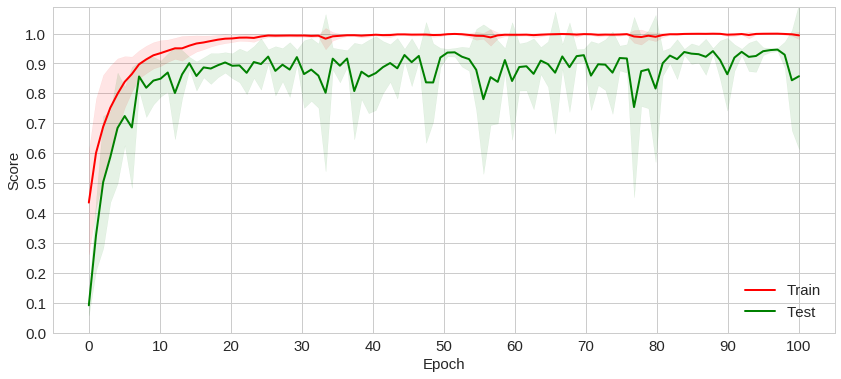

In [33]:
plot_mean_acc(history)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

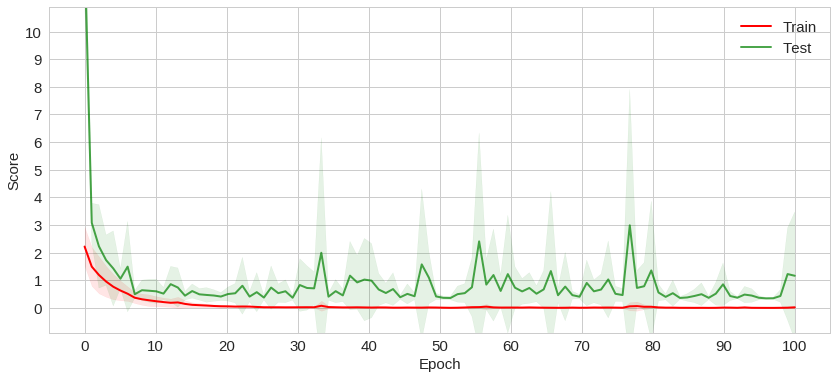

In [35]:
plot_mean_loss(history)